In [1]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import jax

# Lets make a little toy model

In [2]:
data = np.load('Data/first_1_1P.npz')
T = np.log10(data['Y'])[:, :, 0].flatten()
M = np.log10(data['M'].flatten()*1e10)
data = np.load('Data/first_1_1P_extended.npz')
T_extended = np.log10(data['Y'])[:, :, 0]
M_extended = np.log10(data['M'][:, :, 0]*1e10).flatten()
T_extended[:, 2] = T_extended[0, 2]
M = np.concatenate((M, M_extended))
T = np.concatenate((T, T_extended.flatten()))

params =pd.read_csv('Data/SB28_param_minmax.csv')
param_vals = np.zeros((176, 28))
for i in range(28):
    if bool(params.loc[i, 'LogFlag']):
        param_vals[:, i] = np.log10(params.loc[i, 'FiducialVal'])
    else:
        param_vals[:, i] = params.loc[i, 'FiducialVal']

start = 0
for i in range(28):
    if i<6:
        nsims = 11
    else:
        nsims = 5
    if bool(params.loc[i, 'LogFlag']):
        ps = np.log10(np.logspace(np.log10(params.loc[:, 'MinVal'][i]), np.log10(params.loc[:, 'MaxVal'][i]), nsims, endpoint=True))
    else:
        ps = np.linspace(params.loc[:, 'MinVal'][i], params.loc[:, 'MaxVal'][i], nsims, endpoint=True)
    stop = start +nsims
    param_vals[start:stop, i] = ps
    start = stop    
param_df = pd.DataFrame(param_vals, columns=np.array(params.loc[:, 'ParamName']))
param_df['M'] = M
param_df['Y'] = T
# test_theta =(param_df - param_df.min(axis=0))/(param_df.min(axis=0) - param_df.max(axis=0)) + 1
# test_theta = np.array(test_theta)[:, :-1]


# Now we can use CARPoolGP

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def generate_sobol_theta(lbs, ubs, N, seed, d=7):
    from scipy.stats import qmc
    sampler = qmc.Sobol(d=d, scramble=True, seed=seed)
    sample = sampler.random_base2(m=N)
    theta = qmc.scale(sample, lbs, ubs)
    return theta

def generate_surrogates(theta,lbs, ubs, seed=1939, d=28, Groups=6):
    islands = generate_sobol_theta(lbs[:-1], ubs[:-1], Groups, seed, d=d)
    theta_R = np.zeros_like(theta[:, :-1])
    for i, t in enumerate(theta):
        nearest_island = islands[np.argmin(np.sum((t.reshape(1, -1)[:, :-1]-islands)**2, axis=1))]
        theta_R[i] = nearest_island
    return theta_R, islands

# We use the SB28 parameter bounds
param_path = 'Data/SB28_param_minmax.csv'
df = pd.read_csv(param_path)
lbs = []
ubs = []
for i in df.T:
    if df.loc[i, 'LogFlag'] ==1:
        lbs.append(np.log10(df.loc[i, "MinVal"]))
        ubs.append(np.log10(df.loc[i, "MaxVal"]))
    else:
        lbs.append(df.loc[i, "MinVal"])
        ubs.append(df.loc[i, "MaxVal"])
lbs.append(13.0)
ubs.append(14.5)
lbs = np.array(lbs)
ubs = np.array(ubs)

# Generate theta and the surrogates
theta = generate_sobol_theta(lbs, ubs,7 , 1993, d=29)
theta_R, islands = generate_surrogates(theta, lbs, ubs, d=28)
theta_R = np.hstack((theta_R, theta[:, -1].reshape(128, 1)))
# For the parameters that were generated in log, we need to do 10**parameter
# for i, logflag in zip(np.arange(len(theta.T)), df['LogFlag']):
#     if bool(logflag):
#         theta[:, i] = 10**theta[:, i]
#         theta_R[:, i] = 10**theta_R[:, i]
#         islands[:, i] = 10**islands[:, i]


In [4]:
data = np.log10(np.load('Data/Sims2.npz')['Y'])
surrogate_data = np.log10(np.load('Data/Surrs2.npz')['Y'])
thetap = theta[np.load('Data/Sims2.npz')['N']]
theta_Rp = theta_R[np.load('Data/Surrs2.npz')['N']-128]
thetap[:, -1] = np.log10(np.load('Data/Sims2.npz')['M']*1e10)
theta_Rp[:, -1] = np.log10(np.load('Data/Surrs2.npz')['M']*1e10)
datar = np.log10(np.load('Data/Sims2rusty.npz')['Y'])
surrogate_datar = np.log10(np.load('Data/Surrs2rusty.npz')['Y'])
thetar = theta[np.load('Data/Sims2rusty.npz')['N']]
theta_Rr = theta_R[np.load('Data/Surrs2rusty.npz')['N']-128]
thetar[:, -1] = np.log10(np.load('Data/Sims2rusty.npz')['M']*1e10)
theta_Rr[:, -1] = np.log10(np.load('Data/Surrs2rusty.npz')['M']*1e10)
# theta = theta[:, :-1]
# theta_R = theta_R[:, :-1]


In [5]:
data = np.log10(np.load('Data/Sims2.npz')['Y'])
surrogate_data = np.log10(np.load('Data/Surrs2.npz')['Y'])
thetap = theta[np.load('Data/Sims2.npz')['N']]
theta_Rp = theta_R[np.load('Data/Surrs2.npz')['N']-128]
thetap[:, -1] = np.log10(np.load('Data/Sims2.npz')['M']*1e10)
theta_Rp[:, -1] = np.log10(np.load('Data/Surrs2.npz')['M']*1e10)
datar = np.log10(np.load('Data/Sims2rusty.npz')['Y'])
surrogate_datar = np.log10(np.load('Data/Surrs2rusty.npz')['Y'])
thetar = theta[np.load('Data/Sims2rusty.npz')['N']]
theta_Rr = theta_R[np.load('Data/Surrs2rusty.npz')['N']-128]
thetar[:, -1] = np.log10(np.load('Data/Sims2rusty.npz')['M']*1e10)
theta_Rr[:, -1] = np.log10(np.load('Data/Surrs2rusty.npz')['M']*1e10)
data = np.concatenate((data, datar))
surrogate_data = np.concatenate((surrogate_data, surrogate_datar))
theta_ = np.concatenate((thetap,thetar))
theta_R_ = np.concatenate((theta_Rp, theta_Rr))

In [6]:
data = np.log10(10**data / (10**theta_[:, -1])**(5/3))
surrogate_data = np.log10(10**surrogate_data / (10**theta_R_[:, -1])**(5/3))

In [7]:
X   = (theta_    - lbs)/(lbs - ubs) + 1
X_R = (theta_R_  - lbs)/(lbs - ubs) + 1

In [50]:
    data = np.log10(np.load('Data/Sims2.npz')['Y'])
    surrogate_data = np.log10(np.load('Data/Surrs2.npz')['Y'])
    thetap = theta[np.load('Data/Sims2.npz')['N']]
    theta_Rp = theta_R[np.load('Data/Surrs2.npz')['N']-128]
    thetap[:, -1] = np.log10(np.load('Data/Sims2.npz')['M']*1e10)
    theta_Rp[:, -1] = np.log10(np.load('Data/Surrs2.npz')['M']*1e10)
    datar = np.log10(np.load('Data/Sims2rusty.npz')['Y'])
    surrogate_datar = np.log10(np.load('Data/Surrs2rusty.npz')['Y'])
    thetar = theta[np.load('Data/Sims2rusty.npz')['N']]
    theta_Rr = theta_R[np.load('Data/Surrs2rusty.npz')['N']-128]
    thetar[:, -1] = np.log10(np.load('Data/Sims2rusty.npz')['M']*1e10)
    theta_Rr[:, -1] = np.log10(np.load('Data/Surrs2rusty.npz')['M']*1e10)
    data = np.concatenate((data, datar))
    surrogate_data = np.concatenate((surrogate_data, surrogate_datar))
    theta_ = np.concatenate((thetap,thetar))
    theta_R_ = np.concatenate((theta_Rp, theta_Rr))
    data = np.log10(10**data / (10**theta_[:, -1])**(5/3))
    surrogate_data = np.log10(10**surrogate_data / (10**theta_R_[:, -1])**(5/3))
    X   = (theta_    - lbs)/(lbs - ubs) + 1
    X_R = (theta_R_  - lbs)/(lbs - ubs) + 1
    # split_indices = iii#np.random.choice(np.arange(123), 1, replace=False)

    # Xtest = X[split_indices]
    # X = np.delete(X, split_indices, axis=0)

    # data_test = data[split_indices]
    # data = np.delete(data, split_indices, axis=0)
    # Test_list.append(data_test)
    from src import CARPoolSimulations

    # Create simulation objects and surrogate objects
    sims = CARPoolSimulations.Simulation()
    surrs = CARPoolSimulations.Simulation()

    # Set the parameters and quantities for these simulations
    sims.parameters = X; sims.quantities=data
    surrs.parameters = X_R; surrs.quantities=surrogate_data
    from src import CARPoolEmulator

    #Build an emulator 
    emuCP = CARPoolEmulator.Emulator(sims, surrs)

    #Initialize some set of parameters (or default)
    params = {"log_scaleV"   :7*np.ones(emuCP.param_dimensions),
            "log_scaleX"     :0*np.ones(emuCP.param_dimensions),
            "log_scaleW"     :7*np.ones(emuCP.param_dimensions),
            "log_scaleM"     :7*np.ones(emuCP.param_dimensions),
            "log_ampV"       :0.5*np.ones(emuCP.param_dimensions),
            "log_ampW"       :0.3*np.ones(emuCP.param_dimensions),
            "log_ampX"       :0.*np.ones(emuCP.param_dimensions),                
            "log_deltaP"     :0*np.ones(emuCP.param_dimensions),
            "log_jitterV"    :0.0,
            "log_jitterW"    :0.0,
            "log_mean"       :0.0}

    # Train the emulator
    best_params = emuCP.train(params,learning_rate=1e-3, max_iterations=500)
    MCP, VCP = emuCP.predict(multithetatest)

In [90]:
Ms_list = []
Vs_list = []
Test_list = []
for iii in range(123):
    data = np.log10(np.load('Data/Sims2.npz')['Y'])
    surrogate_data = np.log10(np.load('Data/Surrs2.npz')['Y'])
    thetap = theta[np.load('Data/Sims2.npz')['N']]
    theta_Rp = theta_R[np.load('Data/Surrs2.npz')['N']-128]
    thetap[:, -1] = np.log10(np.load('Data/Sims2.npz')['M']*1e10)
    theta_Rp[:, -1] = np.log10(np.load('Data/Surrs2.npz')['M']*1e10)
    datar = np.log10(np.load('Data/Sims2rusty.npz')['Y'])
    surrogate_datar = np.log10(np.load('Data/Surrs2rusty.npz')['Y'])
    thetar = theta[np.load('Data/Sims2rusty.npz')['N']]
    theta_Rr = theta_R[np.load('Data/Surrs2rusty.npz')['N']-128]
    thetar[:, -1] = np.log10(np.load('Data/Sims2rusty.npz')['M']*1e10)
    theta_Rr[:, -1] = np.log10(np.load('Data/Surrs2rusty.npz')['M']*1e10)
    data = np.concatenate((data, datar))
    surrogate_data = np.concatenate((surrogate_data, surrogate_datar))
    theta_ = np.concatenate((thetap,thetar))
    theta_R_ = np.concatenate((theta_Rp, theta_Rr))
    data = np.log10(10**data / (10**theta_[:, -1])**(5/3))
    surrogate_data = np.log10(10**surrogate_data / (10**theta_R_[:, -1])**(5/3))
    X   = (theta_    - lbs)/(lbs - ubs) + 1
    X_R = (theta_R_  - lbs)/(lbs - ubs) + 1
    split_indices = iii#np.random.choice(np.arange(123), 1, replace=False)

    Xtest = X[split_indices]
    X = np.delete(X, split_indices, axis=0)

    data_test = data[split_indices]
    data = np.delete(data, split_indices, axis=0)
    Test_list.append(data_test)
    from src import CARPoolSimulations

    # Create simulation objects and surrogate objects
    sims = CARPoolSimulations.Simulation()
    surrs = CARPoolSimulations.Simulation()

    # Set the parameters and quantities for these simulations
    sims.parameters = X; sims.quantities=data
    surrs.parameters = X_R; surrs.quantities=surrogate_data
    from src import CARPoolEmulator

    #Build an emulator 
    emuCP = CARPoolEmulator.Emulator(sims, surrs)

    #Initialize some set of parameters (or default)
    params = {"log_scaleV"   :7*np.ones(emuCP.param_dimensions),
            "log_scaleX"     :0*np.ones(emuCP.param_dimensions),
            "log_scaleW"     :7*np.ones(emuCP.param_dimensions),
            "log_scaleM"     :7*np.ones(emuCP.param_dimensions),
            "log_ampV"       :0.5*np.ones(emuCP.param_dimensions),
            "log_ampW"       :0.3*np.ones(emuCP.param_dimensions),
            "log_ampX"       :0.*np.ones(emuCP.param_dimensions),                
            "log_deltaP"     :0*np.ones(emuCP.param_dimensions),
            "log_jitterV"    :0.0,
            "log_jitterW"    :0.0,
            "log_mean"       :0.0}

    # Train the emulator
    best_params = emuCP.train(params,learning_rate=1e-3, max_iterations=500)
    MCP, VCP = emuCP.predict(Xtest[np.newaxis])
    Ms_list.append(MCP)
    Vs_list.append(VCP)


In [80]:
X[0][np.newaxis].shape

(1, 29)

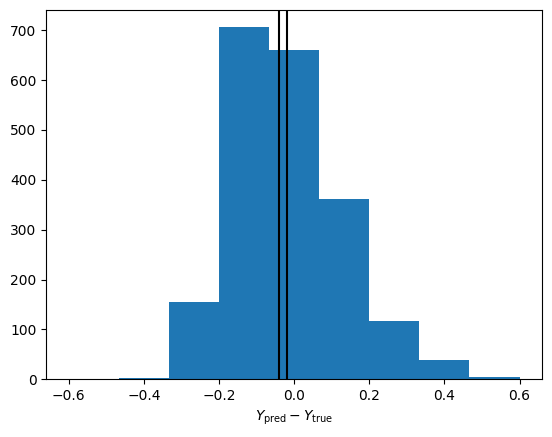

In [114]:
MCP, VCP = emuCP.predict(multithetatest)
plt.figure()
i=-3
_ = plt.hist(MCP - Y_mean, bins=np.linspace(-0.6, 0.6, 10), alpha=1)
plt.xlabel(r'$Y_{\rm pred} - Y_{\rm true}$')
plt.axvline(np.mean(MCP - Y_mean), color='k')
plt.axvline(np.median(MCP - Y_mean), color='k')


In [82]:
data = np.log10(np.load('Data/Sims2.npz')['Y'])
surrogate_data = np.log10(np.load('Data/Surrs2.npz')['Y'])
thetap = theta[np.load('Data/Sims2.npz')['N']]
theta_Rp = theta_R[np.load('Data/Surrs2.npz')['N']-128]
thetap[:, -1] = np.log10(np.load('Data/Sims2.npz')['M']*1e10)
theta_Rp[:, -1] = np.log10(np.load('Data/Surrs2.npz')['M']*1e10)
datar = np.log10(np.load('Data/Sims2rusty.npz')['Y'])
surrogate_datar = np.log10(np.load('Data/Surrs2rusty.npz')['Y'])
thetar = theta[np.load('Data/Sims2rusty.npz')['N']]
theta_Rr = theta_R[np.load('Data/Surrs2rusty.npz')['N']-128]
thetar[:, -1] = np.log10(np.load('Data/Sims2rusty.npz')['M']*1e10)
theta_Rr[:, -1] = np.log10(np.load('Data/Surrs2rusty.npz')['M']*1e10)
data = np.concatenate((data, datar))
surrogate_data = np.concatenate((surrogate_data, surrogate_datar))
theta_ = np.concatenate((thetap,thetar))
theta_R_ = np.concatenate((theta_Rp, theta_Rr))
data = np.log10(10**data / (10**theta_[:, -1])**(5/3))
surrogate_data = np.log10(10**surrogate_data / (10**theta_R_[:, -1])**(5/3))
X   = (theta_    - lbs)/(lbs - ubs) + 1
X_R = (theta_R_  - lbs)/(lbs - ubs) + 1

In [83]:
np.shape(res)

(123, 2048)

In [89]:
Ms_list

[]

In [95]:
np.shape(res)

(123, 1)

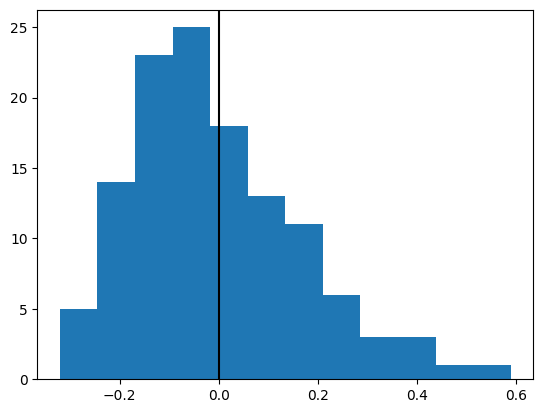

In [127]:
res = []
means = []
for M, V, T in zip(Ms_list, Vs_list, Test_list):
    res.append((M - T))
    means.append(np.mean(M-T))
# plt.hist(res)
plt.hist(np.ravel(res), bins=12)
plt.axvline(np.mean(res), c='k')
# plt.axvline(np.median(res), c='k')

In [135]:
bins = [13, 13.5, 14, 15]
# Getting indices of bins
ind = np.digitize(theta_[:, -1], bins, right=True)

TypeError: only integer scalar arrays can be converted to a scalar index

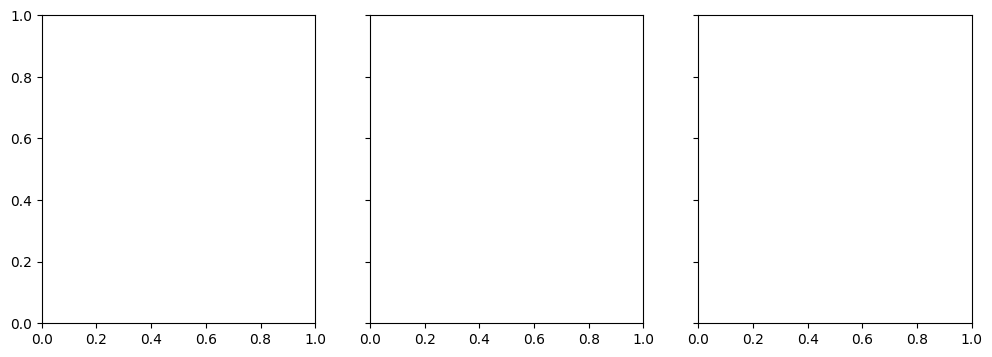

In [136]:
fig, axs = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(12, 4))
cs = plt.cm.Reds_r(np.linspace(0, 1, 4))
labels = ['13<log(M)<13.5', '13.5<log(M)<14', '14<log(M)<14.5']
for j in range(1, 4):
    _ = axs[j-1].hist(res[ind==j], bins=np.linspace(-0.5, 0.5, 20), alpha=0.5, color='k', label=labels[j-1])
    axs[j-1].axvline(np.mean(res[ind==j]), color='r', label='mean')
    axs[j-1].legend()
    axs[j-1].set_xlabel(r'$Y_{\rm pred} - Y_{\rm true}$')

In [128]:
(len(means) - 1) * (np.mean(res))

0.04973531973048537

In [121]:
Vs_list[0]

DeviceArray([[0.00426648]], dtype=float64)

(array([ 3., 12., 10., 23., 26., 15., 17., 10.,  5.,  2.]),
 array([0.04438478, 0.04695588, 0.04952697, 0.05209806, 0.05466916,
        0.05724025, 0.05981134, 0.06238244, 0.06495353, 0.06752462,
        0.07009572]),
 <BarContainer object of 10 artists>)

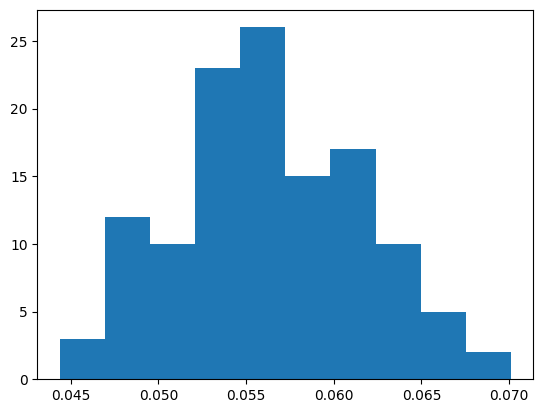

In [125]:
res = []
means = []
for M, V, T in zip(Ms_list, Vs_list, Test_list):
    res.append(V)
    means.append(np.mean(M-T))
# plt.hist(res)
plt.hist(np.sqrt(np.ravel(res)), bins=10)
# plt.axvline(np.mean(res), c='k')
# plt.axvline(np.median(res), c='k')

In [ ]:
test_theta = np.array(param_df)[:, :-1]
test_theta =(test_theta- lbs)/(lbs - ubs) + 1


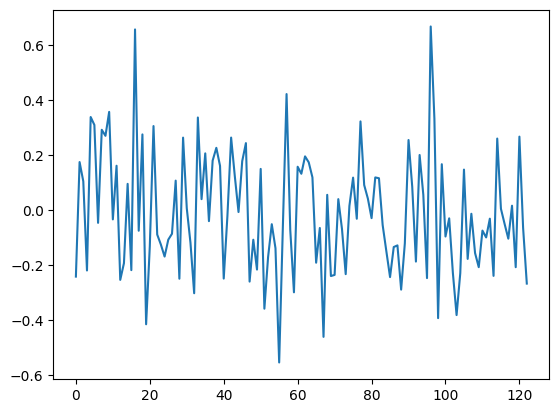

In [46]:
plt.plot(means)

In [272]:
test_theta = np.array(param_df)[:, :-1]
test_theta =(test_theta- lbs)/(lbs - ubs) + 1


In [273]:
from src import CARPoolSimulations

# Create simulation objects and surrogate objects
sims = CARPoolSimulations.Simulation()
surrs = CARPoolSimulations.Simulation()

# Set the parameters and quantities for these simulations
sims.parameters = X; sims.quantities=data
surrs.parameters = X_R; surrs.quantities=surrogate_data

In [274]:
from src import CARPoolEmulator

#Build an emulator 
emuCP = CARPoolEmulator.Emulator(sims, surrs)

#Initialize some set of parameters (or default)
params = {"log_scaleV"   :7*np.ones(emuCP.param_dimensions),
        "log_scaleX"     :0*np.ones(emuCP.param_dimensions),
        "log_scaleW"     :7*np.ones(emuCP.param_dimensions),
        "log_scaleM"     :7*np.ones(emuCP.param_dimensions),
        "log_ampV"       :0.5*np.ones(emuCP.param_dimensions),
        "log_ampW"       :0.3*np.ones(emuCP.param_dimensions),
        "log_ampX"       :0.*np.ones(emuCP.param_dimensions),                
        "log_deltaP"     :0*np.ones(emuCP.param_dimensions),
        "log_jitterV"    :0.0,
        "log_jitterW"    :0.0,
        "log_mean"       :0.0}
# params = {"log_scaleV"   :0*np.ones(emuCP.param_dimensions),
#         "log_scaleX"     :0*np.ones(emuCP.param_dimensions),
#         "log_scaleW"     :0*np.ones(emuCP.param_dimensions),
#         "log_scaleM"     :0*np.ones(emuCP.param_dimensions),
#         "log_ampV"       :0*np.ones(emuCP.param_dimensions),
#         "log_ampW"       :0*np.ones(emuCP.param_dimensions),
#         "log_ampX"       :0.*np.ones(emuCP.param_dimensions),                
#         "log_deltaP"     :0*np.ones(emuCP.param_dimensions),
#         "log_jitterV"    :0.0,
#         "log_jitterW"    :0.0,
#         "log_mean"       :0.0}
# Train the emulator
best_params = emuCP.train(params,learning_rate=1e-3, max_iterations=5000)

# now emulate! 
pred_mean, pred_var = emuCP.predict(test_theta)

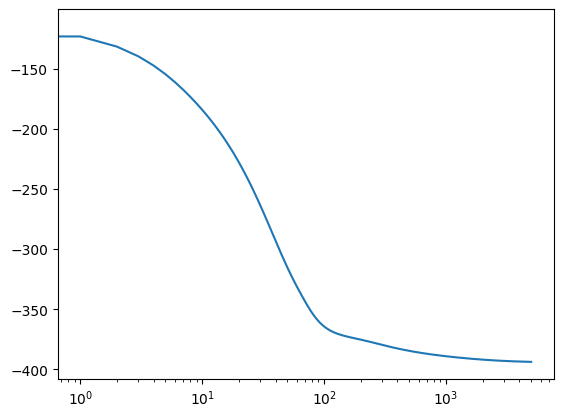

In [275]:
plt.semilogx(emuCP.losses[0])

In [11]:
# Lets read in only the most massive halo
data = np.load('Data/first_1_SB28.npz')
usable_data = np.nonzero(data['Y'])[0]
Y_mean = np.log10(data['Y'][usable_data, 0])
Mass = np.log10(data['M'][usable_data, 0]*1e10)
Y_mean = np.log10(10**Y_mean / (10**Mass)**(5/3))


# Mass = (Mass - Mass.min())/(Mass.max())

params = np.load('Data/SB28_params.npy')[usable_data, :]
params_ =pd.read_csv('Data/SB28_param_minmax.csv')

multithetatest = np.vstack((params.T, Mass.T)).T
# X = params
for i, Xi in enumerate(multithetatest.T[:-1]):
    if params_['LogFlag'][i] == 1:
        multithetatest[:, i] = np.log10(multithetatest[:, i])
multithetatest = (multithetatest -lbs)/(lbs - ubs) + 1
# X = X[:, :-1]

In [53]:
MCP, VCP = emuCP.predict(multithetatest)
plt.figure()
i=-3
_ = plt.hist(MCP - Y_mean, bins=np.linspace(-0.6, 0.6, 10), alpha=1)
plt.xlabel(r'$Y_{\rm pred} - Y_{\rm true}$')
# plt.axvline(np.mean(MCP - Y_mean), color='k')


In [278]:
from matplotlib.colors import LogNorm
from matplotlib import cm, colors
import matplotlib.pyplot as plt

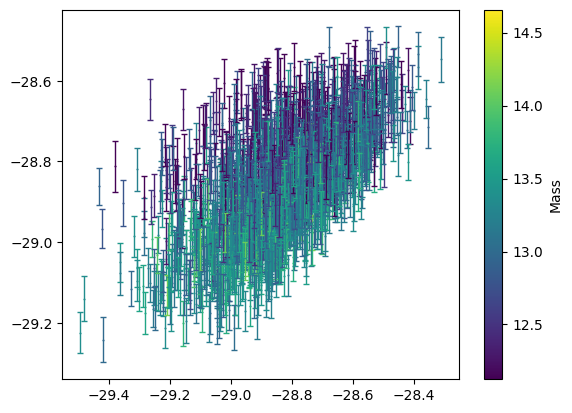

In [49]:
import matplotlib
import matplotlib.cm as cm
norm = colors.Normalize(vmin=13, vmax=15)
mapper = cm.ScalarMappable(norm=norm, cmap='viridis',)
color = np.array([(mapper.to_rgba(v)) for v in Mass])
#create a scatter plot
sc = plt.scatter(Y_mean,MCP,s=0,c=Mass)

#create colorbar according to the scatter plot
clb = plt.colorbar(sc)
clb.set_label('Mass')
#loop over each data point to plot
for x, y, e, color in zip(Y_mean, MCP, np.sqrt(np.diag(VCP)), color):
    plt.plot(x, y, '.', color=color, markersize=1)
    plt.errorbar(x, y, e, lw=1, capsize=2, color=color)
# plt.plot(np.linspace(-9, -4, 100), np.linspace(-9, -4, 100), 'k:', lw=2)



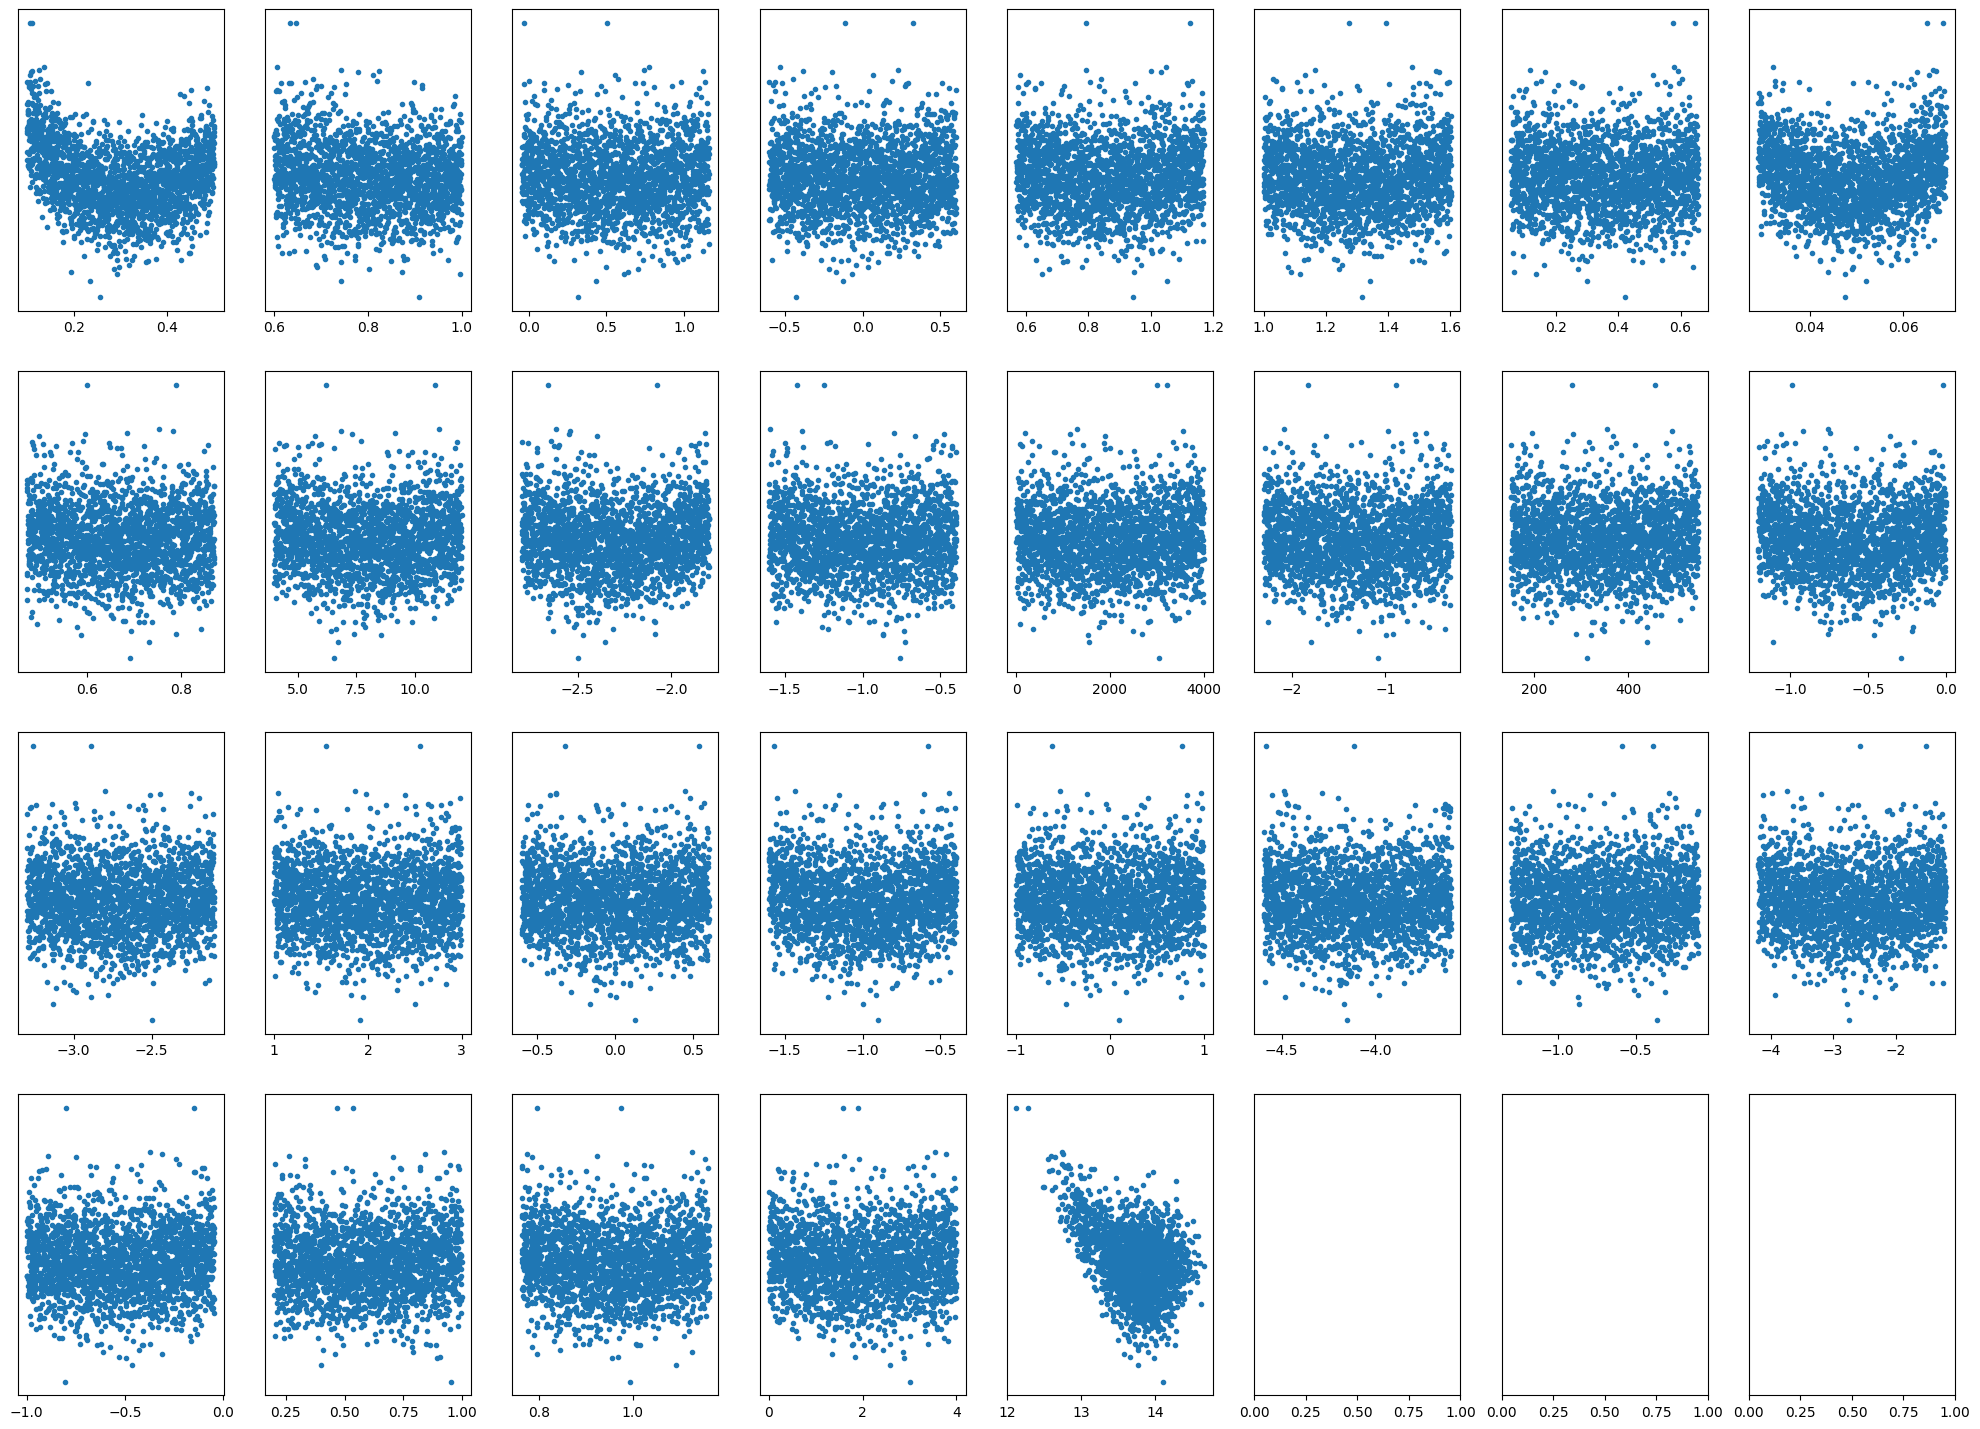

In [59]:
fig, axs = plt.subplots(ncols=8, nrows=4, figsize=(25, 18), sharey=True)
# fig.supxlabel(r'SB28 $Y_{SZ}$')
# fig.supylabel(r'Predicted $Y_{SZ}$')

for i in range(32):
    if i<29:
        if i <28:       
            if params_['LogFlag'][i] == 1:
                p = np.log10(params[:, i])
            else:
                p = params[:, i]
            axs[i//8, i%8].plot(p, np.sqrt(np.diag(VCP)), '.')
            if i%8 != 0:
                axs[i//8, i%8].set_yticks([])
            # if i<24:
            #     axs[i//8, i%8].set_xticks([])
        else:
            axs[i//8, i%8].plot(Mass, np.sqrt(np.diag(VCP)), '.')
            axs[i//8, i%8].set_yticks([])


In [61]:
def add_colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

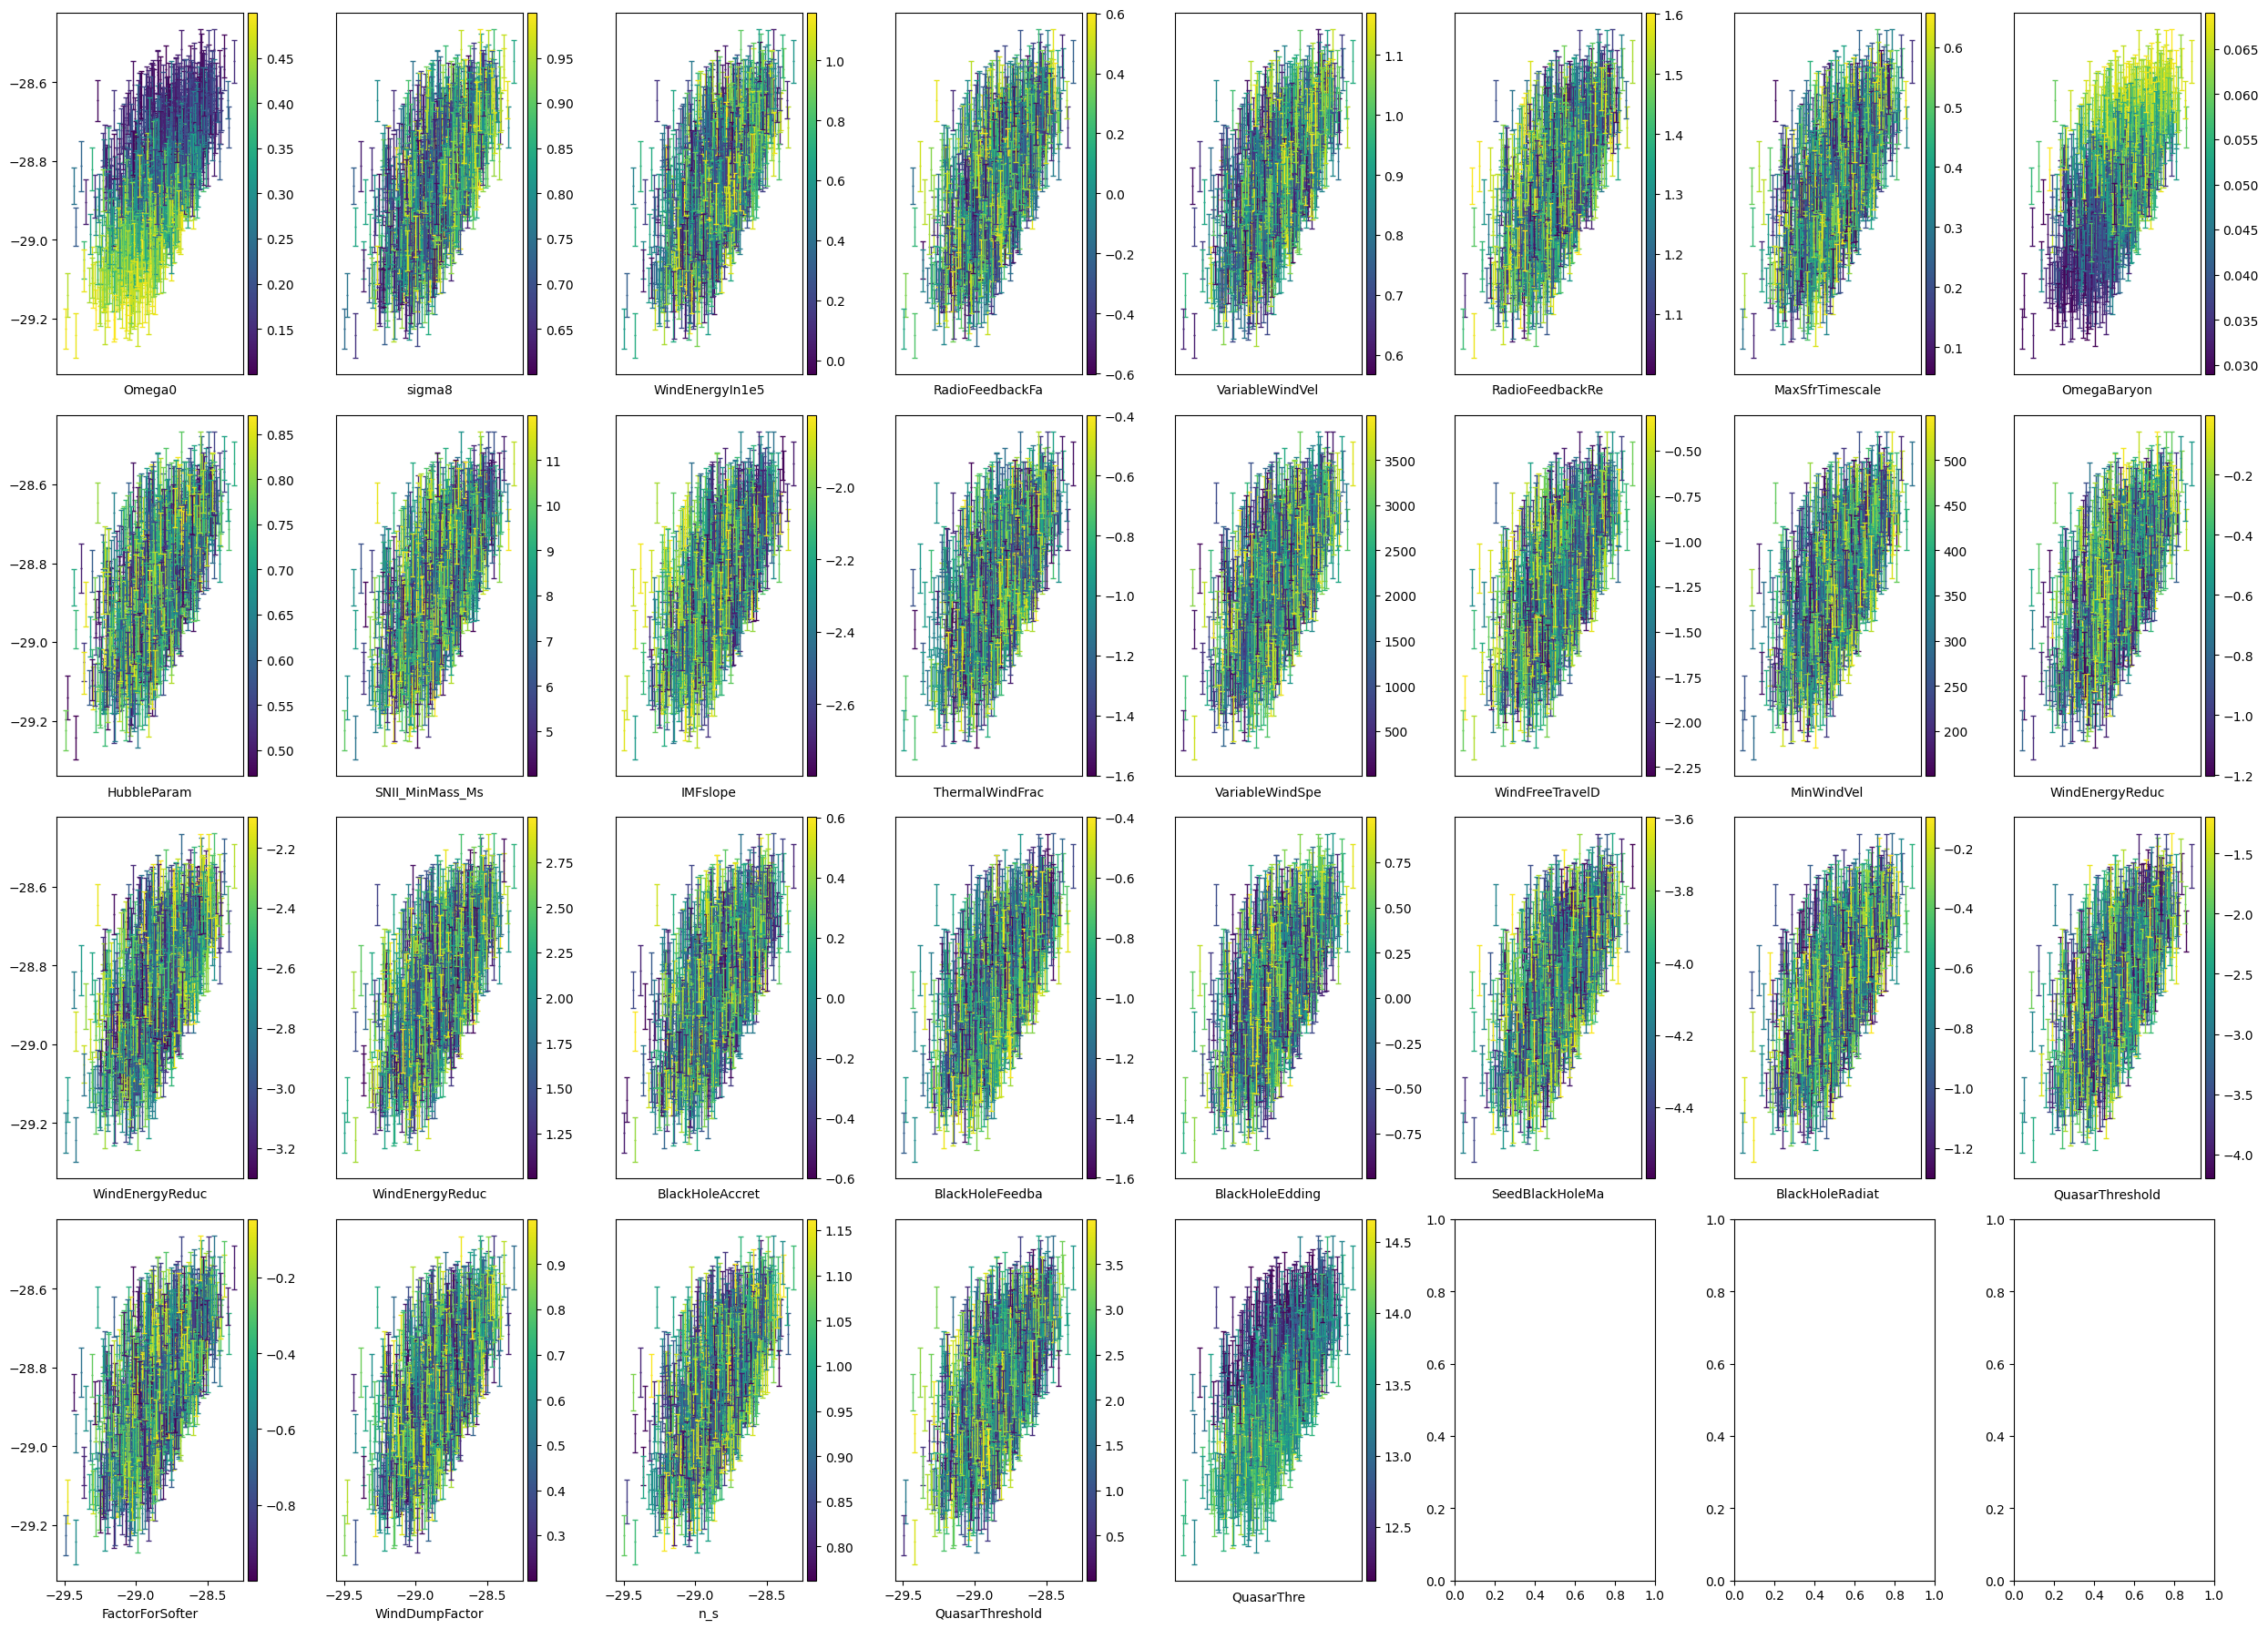

In [63]:
fig, axs = plt.subplots(ncols=8, nrows=4, figsize=(25, 18))
# fig.supxlabel(r'SB28 $Y_{SZ}$')
# fig.supylabel(r'Predicted $Y_{SZ}$')

for i in range(32):
    if i<29:
        if i <28:
            if params_['LogFlag'][i] == 1:
                p = np.log10(params[:, i])
            else:
                p = params[:, i]
            name = params_['ParamName'][i]
                
            norm = colors.Normalize(vmin=lbs[i], vmax=ubs[i])
            mapper = cm.ScalarMappable(norm=norm, cmap='viridis',)
            color = np.array([(mapper.to_rgba(v)) for v in p])
            #create a scatter plot
            sc = axs[i//8, i%8].scatter(Y_mean,MCP,s=0,c=p)
            add_colorbar(sc)
            axs[i//8, i%8].set_xlabel(name[:15])

            # #create colorbar according to the scatter plot
            # clb = plt.colorbar(sc)
            # clb.set_label('Mass')
            #loop over each data point to plot
            for x, y, e, color in zip(Y_mean, MCP, np.sqrt(np.diag(VCP)), color):
                axs[i//8, i%8].plot(x, y, '.', color=color, markersize=1)
                axs[i//8, i%8].errorbar(x, y, e, lw=1, capsize=2, color=color)
            # axs[i//8, i%8].plot(np.linspace(-9, -4, 100), np.linspace(-9, -4, 100), 'k:', lw=2)

            if i%8 != 0:
                axs[i//8, i%8].set_yticks([])
            if i<24:
                axs[i//8, i%8].set_xticks([])
        else:
            p = Mass
                
            norm = colors.Normalize(vmin=lbs[i], vmax=ubs[i])
            mapper = cm.ScalarMappable(norm=norm, cmap='viridis',)
            color = np.array([(mapper.to_rgba(v)) for v in p])
            #create a scatter plot
            sc = axs[i//8, i%8].scatter(Y_mean,MCP,s=0,c=p)
            add_colorbar(sc)
            axs[i//8, i%8].set_xlabel(name[:10])


            # #create colorbar according to the scatter plot
            # clb = plt.colorbar(sc)
            # clb.set_label('Mass')
            #loop over each data point to plot
            for x, y, e, color in zip(Y_mean, MCP, np.sqrt(np.diag(VCP)), color):
                axs[i//8, i%8].plot(x, y, '.', color=color, markersize=1)
                axs[i//8, i%8].errorbar(x, y, e, lw=1, capsize=2, color=color)
            # axs[i//8, i%8].plot(np.linspace(-9, -4, 100), np.linspace(-9, -4, 100), 'k:', lw=2)


            axs[i//8, i%8].set_yticks([])
            axs[i//8, i%8].set_xticks([])

plt.tight_layout()
# plt.savefig('First_Batch.png')

Text(0.5, 0, '$Y_{\\rm pred} - Y_{\\rm true}$')

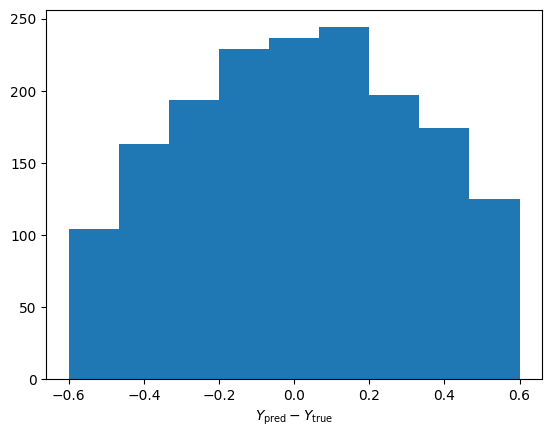

In [280]:
bins = [12, 13, 14, 16]
# Getting indices of bins
ind = np.digitize(Mass, bins, right=True)

In [281]:
bins

[12, 13, 14, 16]

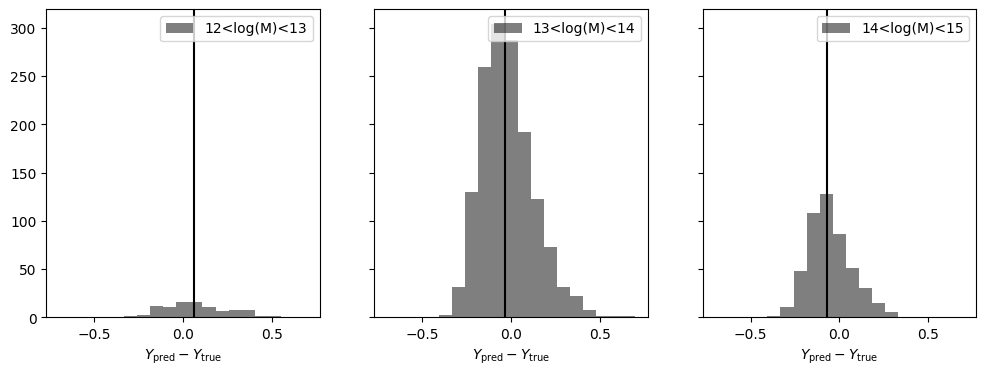

In [180]:
fig, axs = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(12, 4))
cs = plt.cm.Reds_r(np.linspace(0, 1, 4))
labels = ['12<log(M)<13', '13<log(M)<14', '14<log(M)<15']
for j in range(1, 4):
    _ = axs[j-1].hist(MCP[ind==j] - Y_mean[ind==j], bins=np.linspace(-0.7, 0.7, 20), alpha=0.5, color='k', label=labels[j-1])
    axs[j-1].axvline(np.median(MCP[ind==j] - Y_mean[ind==j]), color='k')
    axs[j-1].legend()
    axs[j-1].set_xlabel(r'$Y_{\rm pred} - Y_{\rm true}$')

In [181]:
0.0035**(0.5)

0.05916079783099616

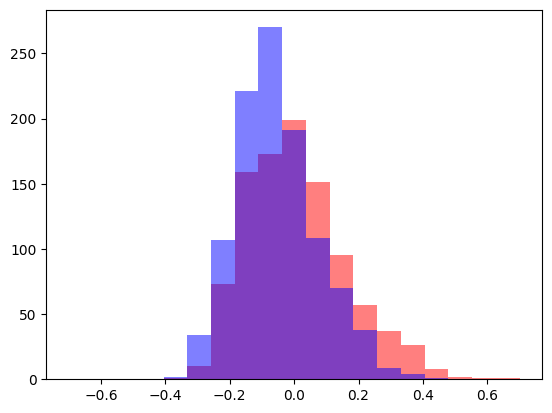

In [182]:
plt.figure()
i=-1
_ = plt.hist(MCP[Mass < (ubs[i] + lbs[i])/2] - Y_mean[Mass < (ubs[i] + lbs[i])/2], bins=np.linspace(-0.7, 0.7, 20), alpha=0.5, color='r')
_ = plt.hist(MCP[Mass > (ubs[i] + lbs[i])/2] - Y_mean[Mass > (ubs[i] + lbs[i])/2], bins=np.linspace(-0.7, 0.7, 20), alpha=0.5, color='b')

# plt.axvline(np.mean(MCP - Y_mean), color='k')


In [183]:
lbs, ubs

(array([ 1.00000000e-01,  6.00000000e-01, -4.57574906e-02, -6.02059991e-01,
         5.68201724e-01,  1.00000000e+00,  5.49958615e-02,  2.90000000e-02,
         4.71100000e-01,  4.00000000e+00, -2.80000000e+00, -1.60205999e+00,
         0.00000000e+00, -2.30103000e+00,  1.50000000e+02, -1.20411998e+00,
        -3.30103000e+00,  1.00000000e+00, -6.02059991e-01, -1.60205999e+00,
        -1.00000000e+00, -4.59660491e+00, -1.30103000e+00, -4.19859629e+00,
        -1.00000000e+00,  2.00000000e-01,  7.62400000e-01,  0.00000000e+00,
         1.30000000e+01]),
 array([ 5.00000000e-01,  1.00000000e+00,  1.15836249e+00,  6.02059991e-01,
         1.17026172e+00,  1.60205999e+00,  6.57055853e-01,  6.90000000e-02,
         8.71100000e-01,  1.20000000e+01, -1.80000000e+00, -3.97940009e-01,
         4.00000000e+03, -3.01029996e-01,  5.50000000e+02,  0.00000000e+00,
        -2.09691001e+00,  3.00000000e+00,  6.02059991e-01, -3.97940009e-01,
         1.00000000e+00, -3.59722293e+00, -9.69100130e-02, -1

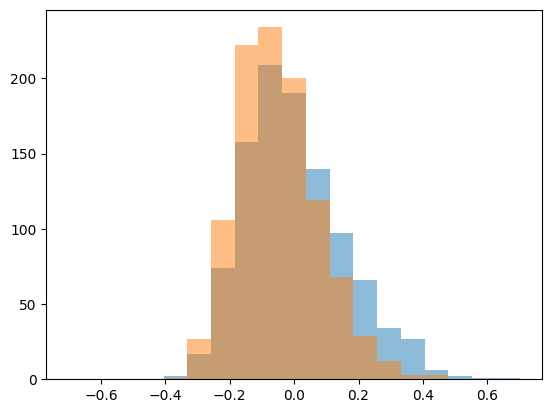

In [184]:
plt.figure()
i=0
_ = plt.hist(MCP[params[:, i] < (ubs[i] + lbs[i])/2] - Y_mean[params[:, i] < (ubs[i] + lbs[i])/2], bins=np.linspace(-0.7, 0.7, 20), alpha=0.5)
_ = plt.hist(MCP[params[:, i] > (ubs[i] + lbs[i])/2] - Y_mean[params[:, i] > (ubs[i] + lbs[i])/2], bins=np.linspace(-0.7, 0.7, 20), alpha=0.5)

# plt.axvline(np.mean(MCP - Y_mean), color='k')


Text(0.5, 0, '$\\sigma_{\\rm Y, pred}$')

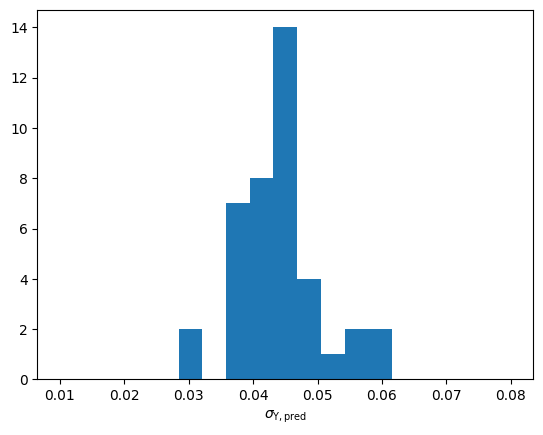

In [282]:
_ = plt.hist(np.sqrt(np.diag(VCP)),bins = np.linspace(0.01, 0.08, 20))
plt.xlabel(r'$\sigma_{\rm Y, pred}$')

# Accounting for missing thetas

In [171]:
N = np.load('Data/Sims2.npz')['N']
Nr = np.load('Data/Sims2rusty.npz')['N']

Nsurr = np.load('Data/Surrs2.npz')['N'] - 128
Nsurrr = np.load('Data/Surrs2rusty.npz')['N']-128

In [172]:
to_sim = theta.copy()
to_sim = np.delete(to_sim, np.concatenate((N, Nr)), axis=0)
to_sim =(to_sim - lbs)/(lbs - ubs) + 1

simd_data, _ = emuCP.predict(to_sim)


to_surr = theta_R.copy()
to_surr = np.delete(to_surr, np.concatenate((Nsurr, Nsurrr)), axis=0)
to_surr = (to_surr - lbs)/(lbs - ubs) + 1
surrd_data, _ = emuCP.predict(to_surr)

    

In [173]:
emuCP.Simulations.update(to_sim, simd_data)
emuCP.Surrogates.update(to_surr, surrd_data)

In [187]:
# Train the emulator
emuCP.train(best_params,learning_rate=1e-3, max_iterations=5000)

# now emulate! 
pred_mean, pred_var = emuCP.predict(test_theta)

KeyboardInterrupt: 

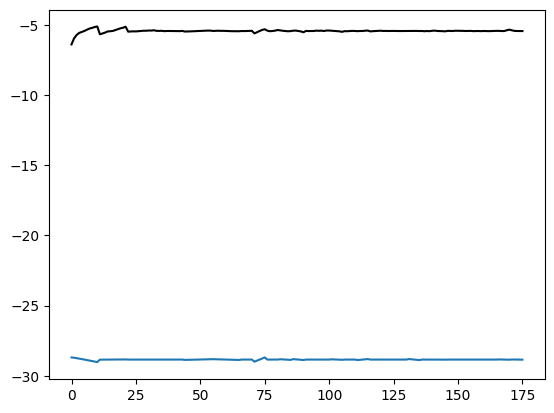

In [175]:
pred_mean, pred_var = emuCP.predict(test_theta)
pred_std = np.sqrt(np.diag(pred_var))
plt.fill_between(np.arange(len(pred_mean)), 
                pred_mean - pred_std, pred_mean+pred_std)
plt.plot(param_df['Y'], c='k')
plt.plot(pred_mean)

# Active learning approach

In [30]:
import time

In [31]:
def chi2(model, data, cov):
    """
    Calculates the chi2 of the emulator.

    Parameters
    ----------
    model : array
        Model values.
    data : array
        Data values.
    covariance : array
        Covariance of the data.

    Returns
    -------
    chi2 : float
        Chi2 of the emulator.
    """
    return np.sum((data - model)**2/ np.sqrt(np.diag(cov)))



In [33]:
X.min(axis=0)

array([ 5.85040078e-04,  6.71716966e-03,  4.80811205e-03,  6.35221694e-03,
        6.22300245e-03,  1.69382431e-04,  6.79717958e-03,  6.18558843e-03,
        5.12483995e-03,  7.39934761e-03,  2.79705320e-03,  3.86347063e-03,
        2.72531155e-03,  3.95618379e-03,  7.08433893e-03,  1.17954891e-03,
        7.17898831e-04,  6.92597032e-03,  2.37235893e-03,  4.82797623e-04,
        7.18474016e-03,  6.96659647e-03,  5.44647407e-03,  1.35700190e-02,
        1.44105032e-03,  3.18048801e-03,  7.55310245e-03,  7.66627397e-03,
       -2.84897292e-01])

In [102]:
params = {"log_scaleV"   :5*np.ones(emuCP.param_dimensions),
        "log_scaleX"     :0*np.ones(emuCP.param_dimensions),
        "log_scaleW"     :5*np.ones(emuCP.param_dimensions),
        "log_scaleM"     :5*np.ones(emuCP.param_dimensions),
        "log_ampV"       :0.5*np.ones(emuCP.param_dimensions),
        "log_ampW"       :0.3*np.ones(emuCP.param_dimensions),
        "log_ampX"       :0.*np.ones(emuCP.param_dimensions),                
        "log_deltaP"     :0*np.ones(emuCP.param_dimensions),
        "log_jitterV"    :-2.0,
        "log_jitterW"    :-2.0,
        "log_mean"       :0.0}
# Now we can iteratively do this:
pred_tests = []
pred_vars = []

# Create simulation objects and surrogate objects
sims  = CARPoolSimulations.Simulation()
surrs = CARPoolSimulations.Simulation()

# Set the parameters and quantities for these simulations
sims.parameters  = X; sims.quantities=data
surrs.parameters = X_R; surrs.quantities=surrogate_data

# Generate an active learning model
emu = CARPoolEmulator.ActiveLearning(sims, surrs, theta, 
                                        np.zeros(29), 
                                        np.ones(29))
emu.Simulations.update(to_sim, simd_data)
emu.Surrogates.update(to_surr, surrd_data)

# Initialize the training
best_params = emu.train(params, learning_rate=1e-3, max_iterations=10000)
start = time.time()
# Run an active learning step to find the next state (Ngrid is for 2**N)
next_thetas, next_surrogates = emu.active_learning_step(num_new=128, Ngrid=10)   
print('Time : ', time.time()-start)

    # next_data, next_noise = generate_model(next_thetas, 
    #                                    uncorr_gp, 
    #                                    Y_mean, 
    #                                    seed=i*123 + 123, sigma=sigma)
    # next_surrogate_data   = generatesurr_model(next_surrogates, uncorr_gp, Y_mean, next_noise)

    # emu.Simulations.update(next_thetas, next_data)
    # emu.Surrogates.update(next_surrogates, next_surrogate_data)

    # best_params = emu.train(params, learning_rate=1e-3, max_iterations=500)
    
    # pred_test, pred_var = emu.predict(multitesttheta)
    # pred_tests.append(pred_test)
    # pred_vars.append(pred_var)
    # print("Time: %f, Pred Var:%f, chi2:%f" % (time.time() - start, 
    #       round(np.sum(np.diag(pred_var)), 3), 

    #       round(chi2(model, pred_test, pred_var), 3)))
# import pickle
# outfile = open('emu_1p_2', 'wb')
# pickle.dump(emu, outfile)
# outfile.close()

Time :  7814.177355051041


In [103]:
next_thetas_real = (next_thetas -1 ) * (lbs - ubs) + lbs
next_surrogates_real = (next_surrogates -1 )* (lbs - ubs) + lbs
np.savez('next_params', theta = next_thetas_real, theta_R = next_surrogates_real)

In [213]:
28323287/147/20

9633.771088435375

In [222]:
next_thetas.shape

NameError: name 'next_thetas' is not defined

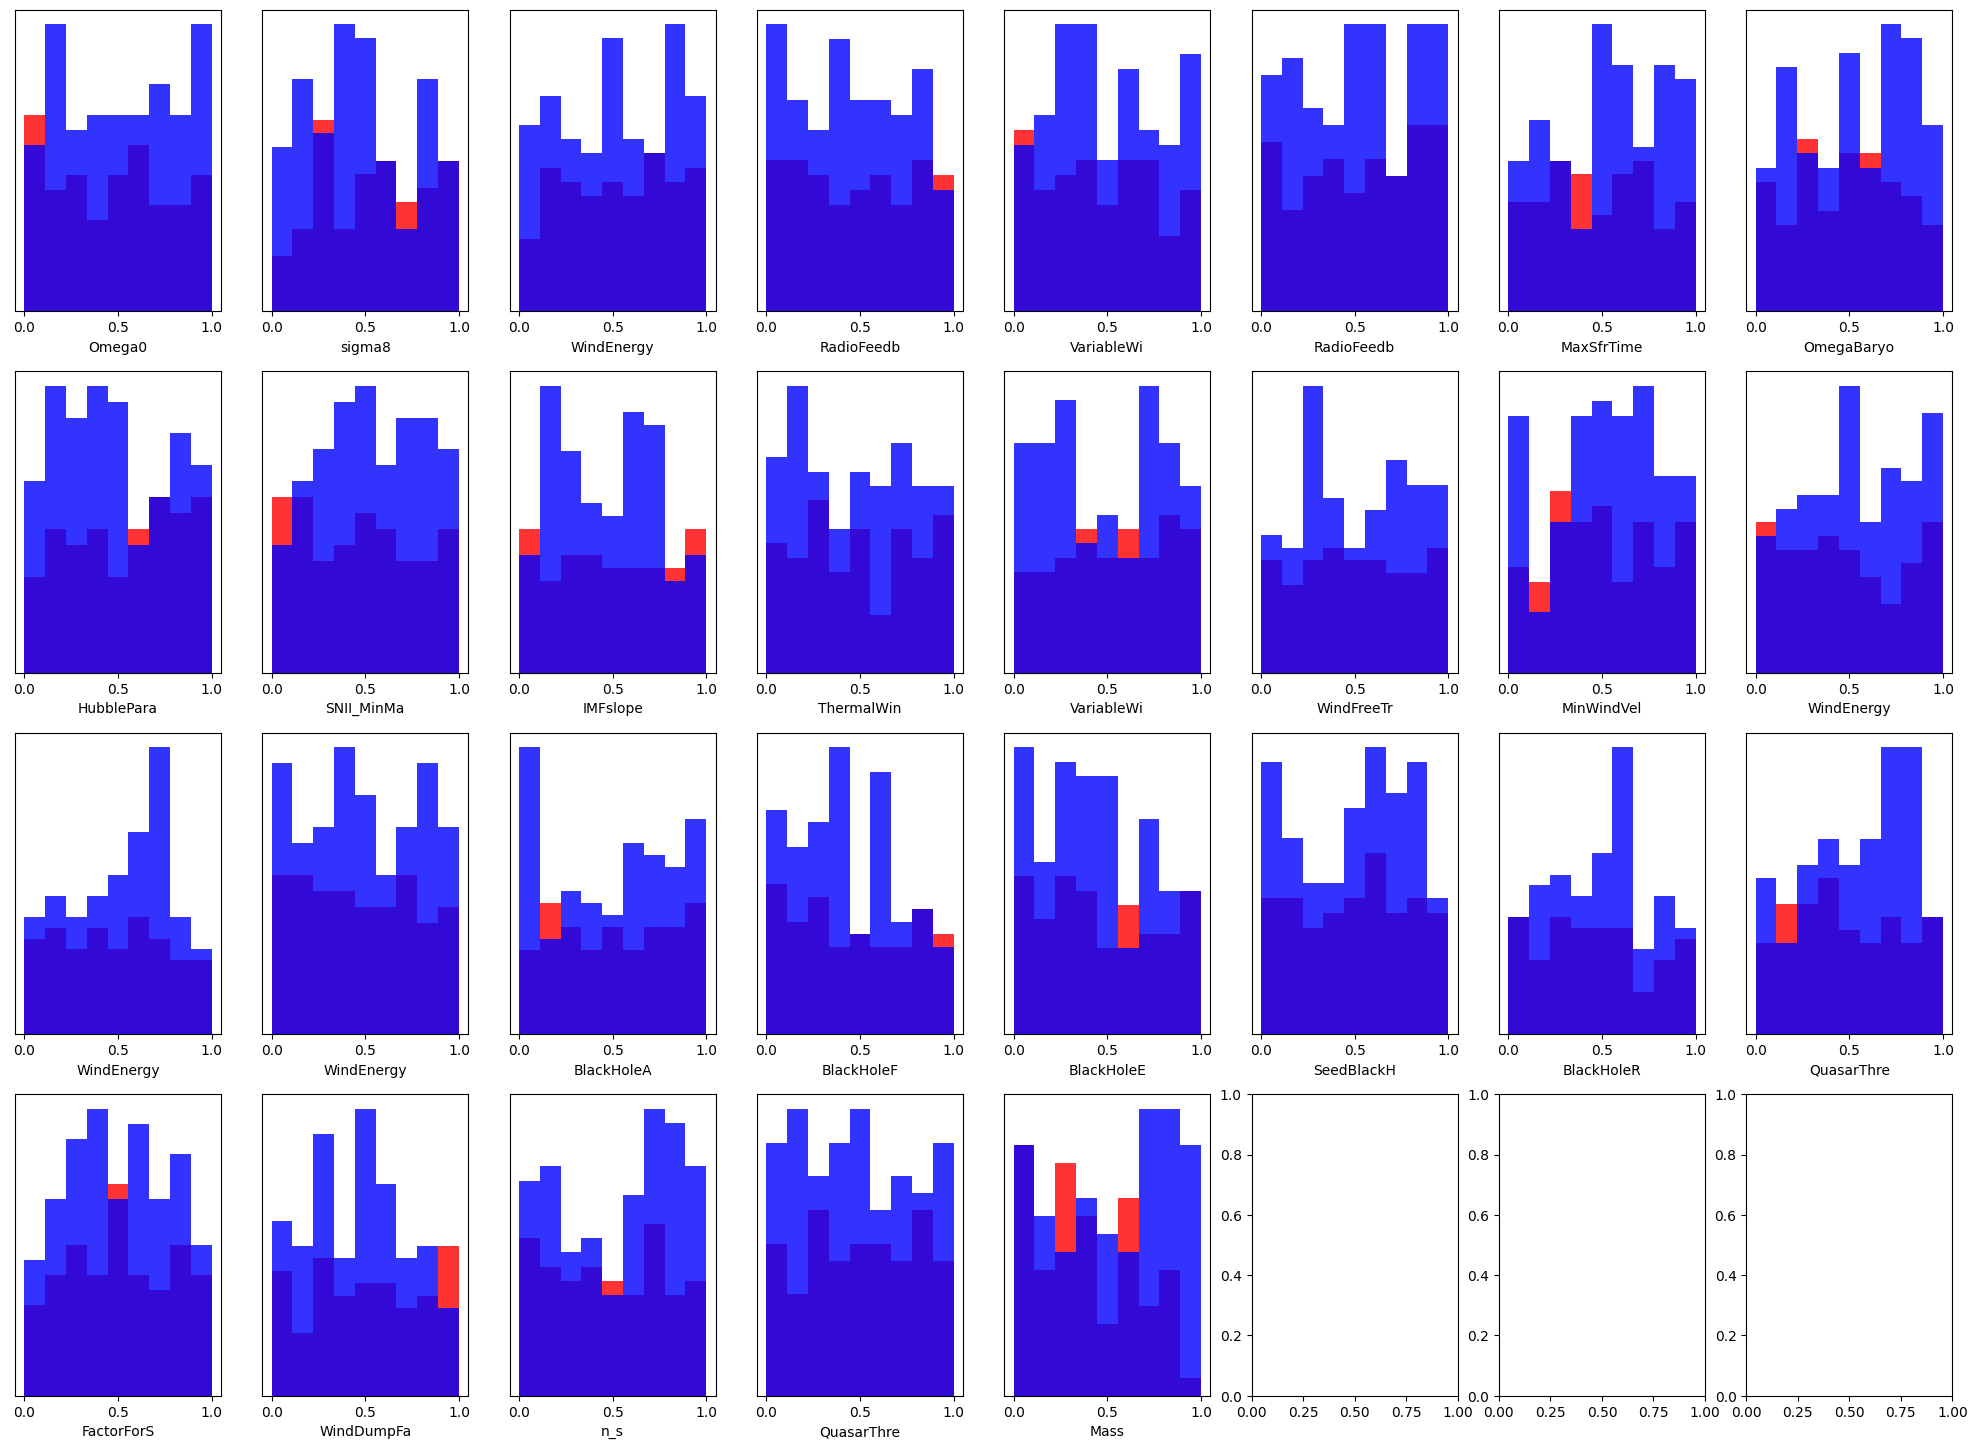

In [104]:
fig, axs = plt.subplots(ncols=8, nrows=4, figsize=(25, 18))
for i in range(32):
    if i<29:
        if i<28:
            axs[i//8, i%8].hist(X[:, i], color='r', alpha=0.8, bins=np.linspace(0, 1, 10))

            axs[i//8, i%8].hist(next_thetas[:, i], color='b', alpha=0.8,bins=np.linspace(0, 1, 10))
            axs[i//8, i%8].set_yticks([])
            axs[i//8, i%8].set_xlabel(df.loc[i, 'ParamName'][:10])

        else:
            axs[i//8, i%8].hist(X[:, i], color='r', alpha=0.8, bins=np.linspace(0, 1, 10))
            axs[i//8, i%8].hist(next_thetas[:, i], color='b', bins=np.linspace(0, 1, 10), alpha=0.8)
            axs[i//8, i%8].set_yticks([])
            axs[i//8, i%8].set_xlabel('Mass')
        axs[i//8, i%8].set_yticks([])


In [720]:
next_thetas_real = (next_thetas -1 ) * (theta.min(axis=0) - theta.max(axis=0)) + np.array(theta.min(axis=0))
next_surrogates_real = (next_surrogates -1 )* (theta.min(axis=0) - theta.max(axis=0)) + np.array(theta.min(axis=0))

In [770]:
next_thetas_real.min(axis=0)

array([ 1.02201126e-01,  6.02474881e-01, -4.24408983e-02, -5.85872888e-01,
        5.73092505e-01,  1.00649014e+00,  6.90738561e-02,  2.99722341e-02,
        4.79325351e-01,  4.09608969e+00, -2.79194927e+00, -1.59000963e+00,
        7.28973269e+01, -2.27719404e+00,  1.59041739e+02, -1.16478933e+00,
       -3.24964062e+00,  1.04668801e+00, -5.86619193e-01, -1.59755597e+00,
       -9.72849407e-01, -4.57792045e+00, -1.29441929e+00, -4.16092188e+00,
       -9.80777365e-01,  2.07860621e-01,  7.68687079e-01,  4.22826078e-02,
        1.30333046e+01])

In [164]:
next_t = np.load('next_params.npz')

In [223]:
next_thetas_real.shape

(128, 29)

In [165]:
next_thetas_real = next_t['theta']
next_surrogates_real = next_t['theta_R']

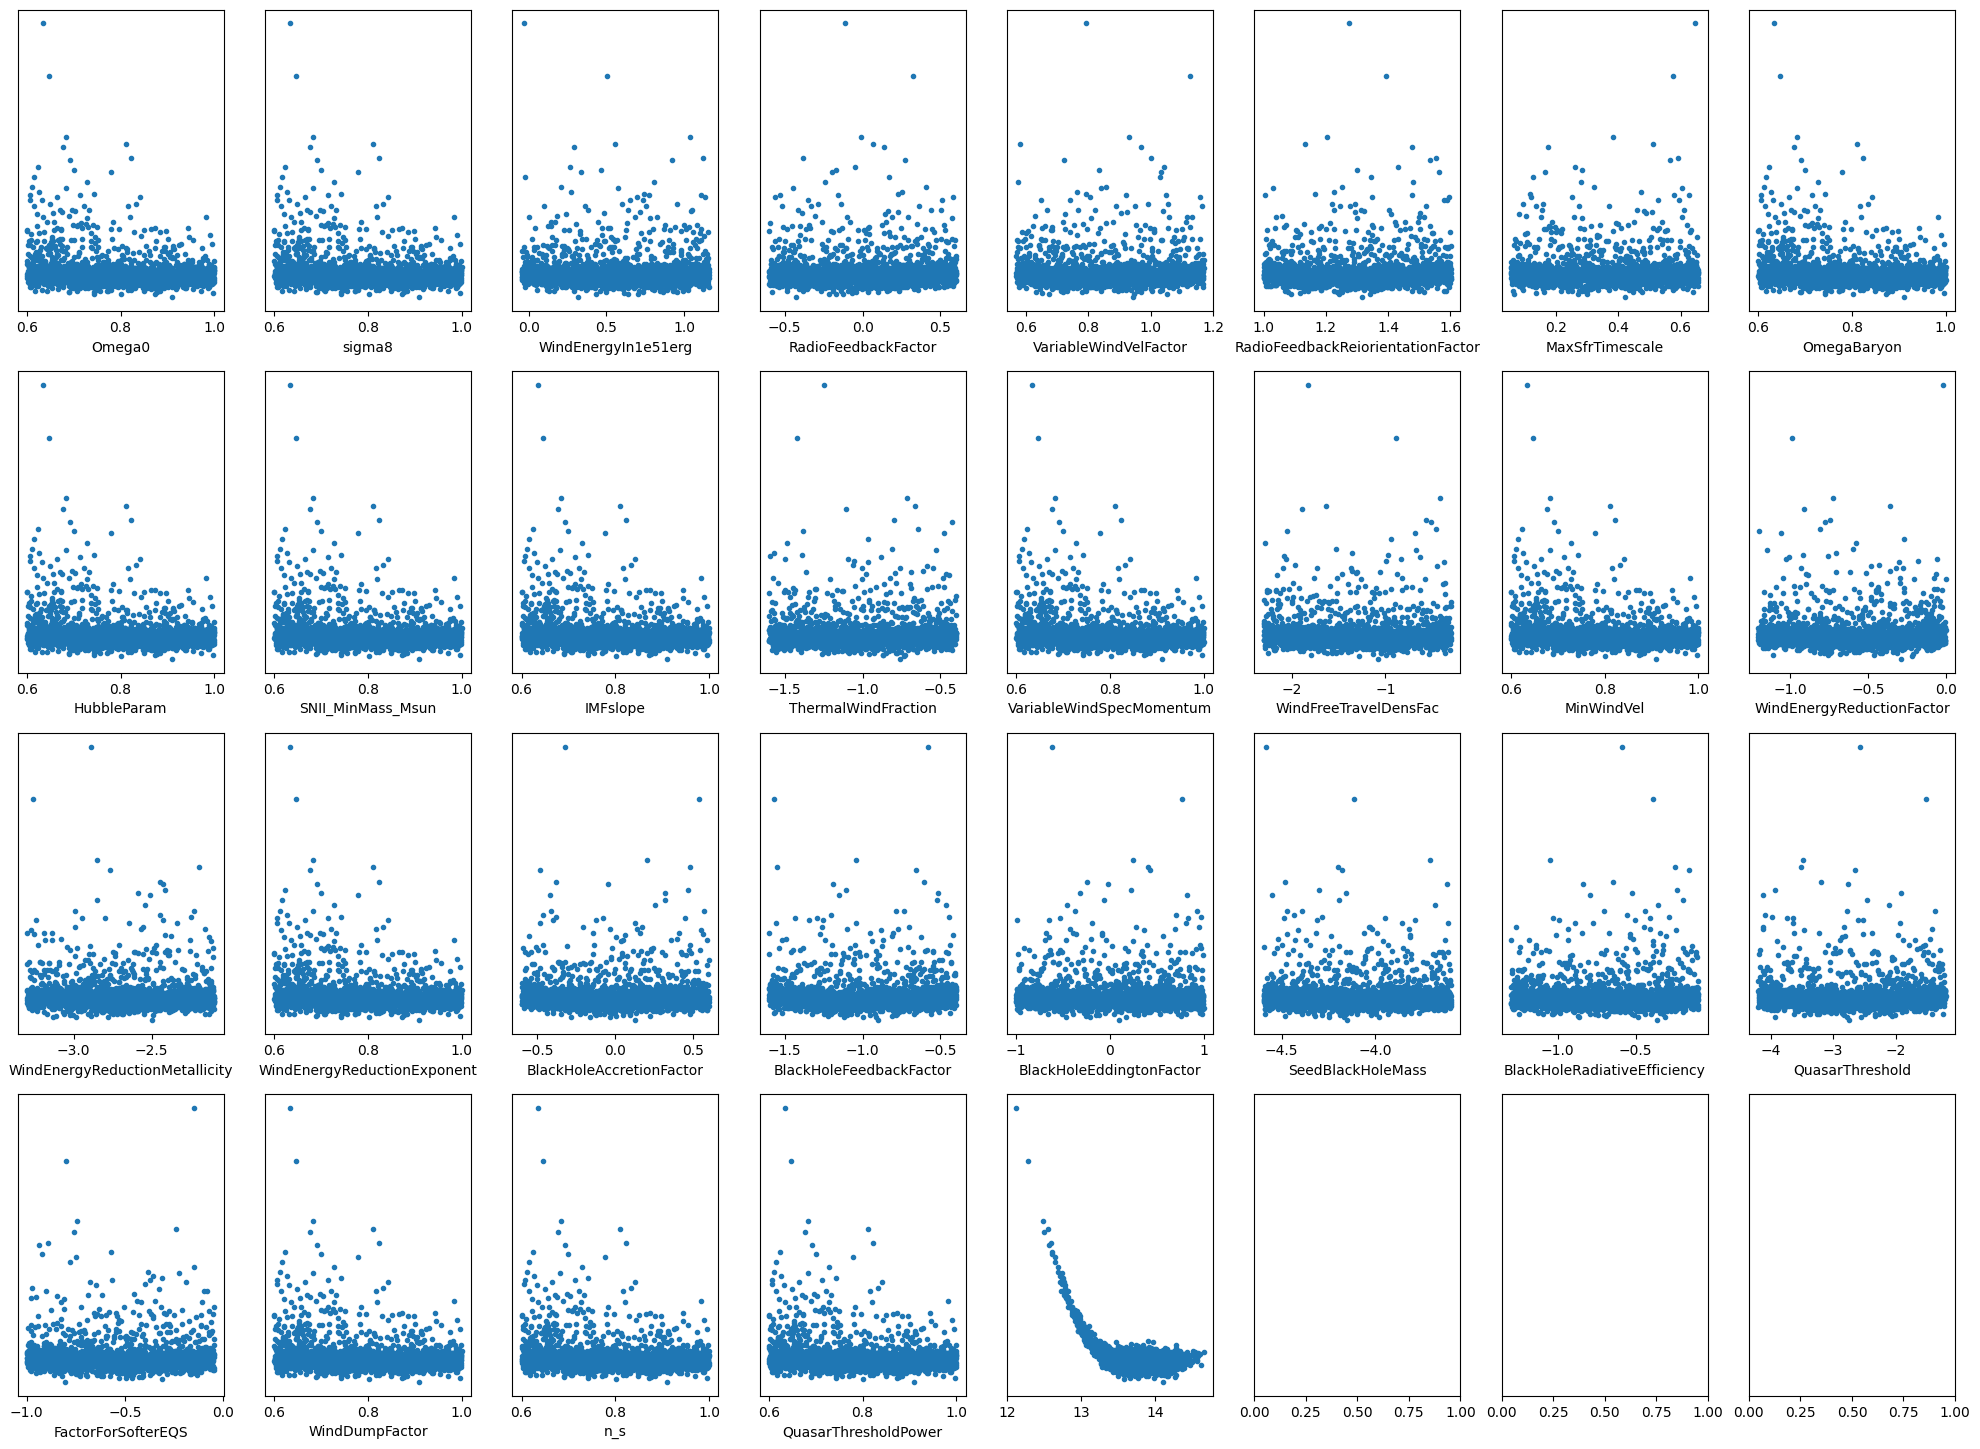

In [170]:
fig, axs = plt.subplots(ncols=8, nrows=4, figsize=(25, 18), sharey=True)
# fig.supxlabel(r'SB28 $Y_{SZ}$')
# fig.supylabel(r'Predicted $Y_{SZ}$')

for i in range(32):
    if i<29:
        if i <28:       
            if params_['LogFlag'][i] == 1:
                p = np.log10(params[:, i])
            else:
                p = params[:, 1]
            axs[i//8, i%8].plot(p, np.sqrt(np.diag(VCP)), '.')
            axs[i//8, i%8].set_xlabel(params_['ParamName'][i])
            if i%8 != 0:
                axs[i//8, i%8].set_yticks([])
            # if i<24:
            #     axs[i//8, i%8].set_xticks([])
        else:
            axs[i//8, i%8].plot(Mass, np.sqrt(np.diag(VCP)), '.')
            axs[i//8, i%8].set_yticks([])


In [197]:
from scipy.stats import binned_statistic
stat = binned_statistic(params[:, 0], np.diag(VCP), statistic='mean', bins=np.linspace(lbs[0], ubs[0], 50))

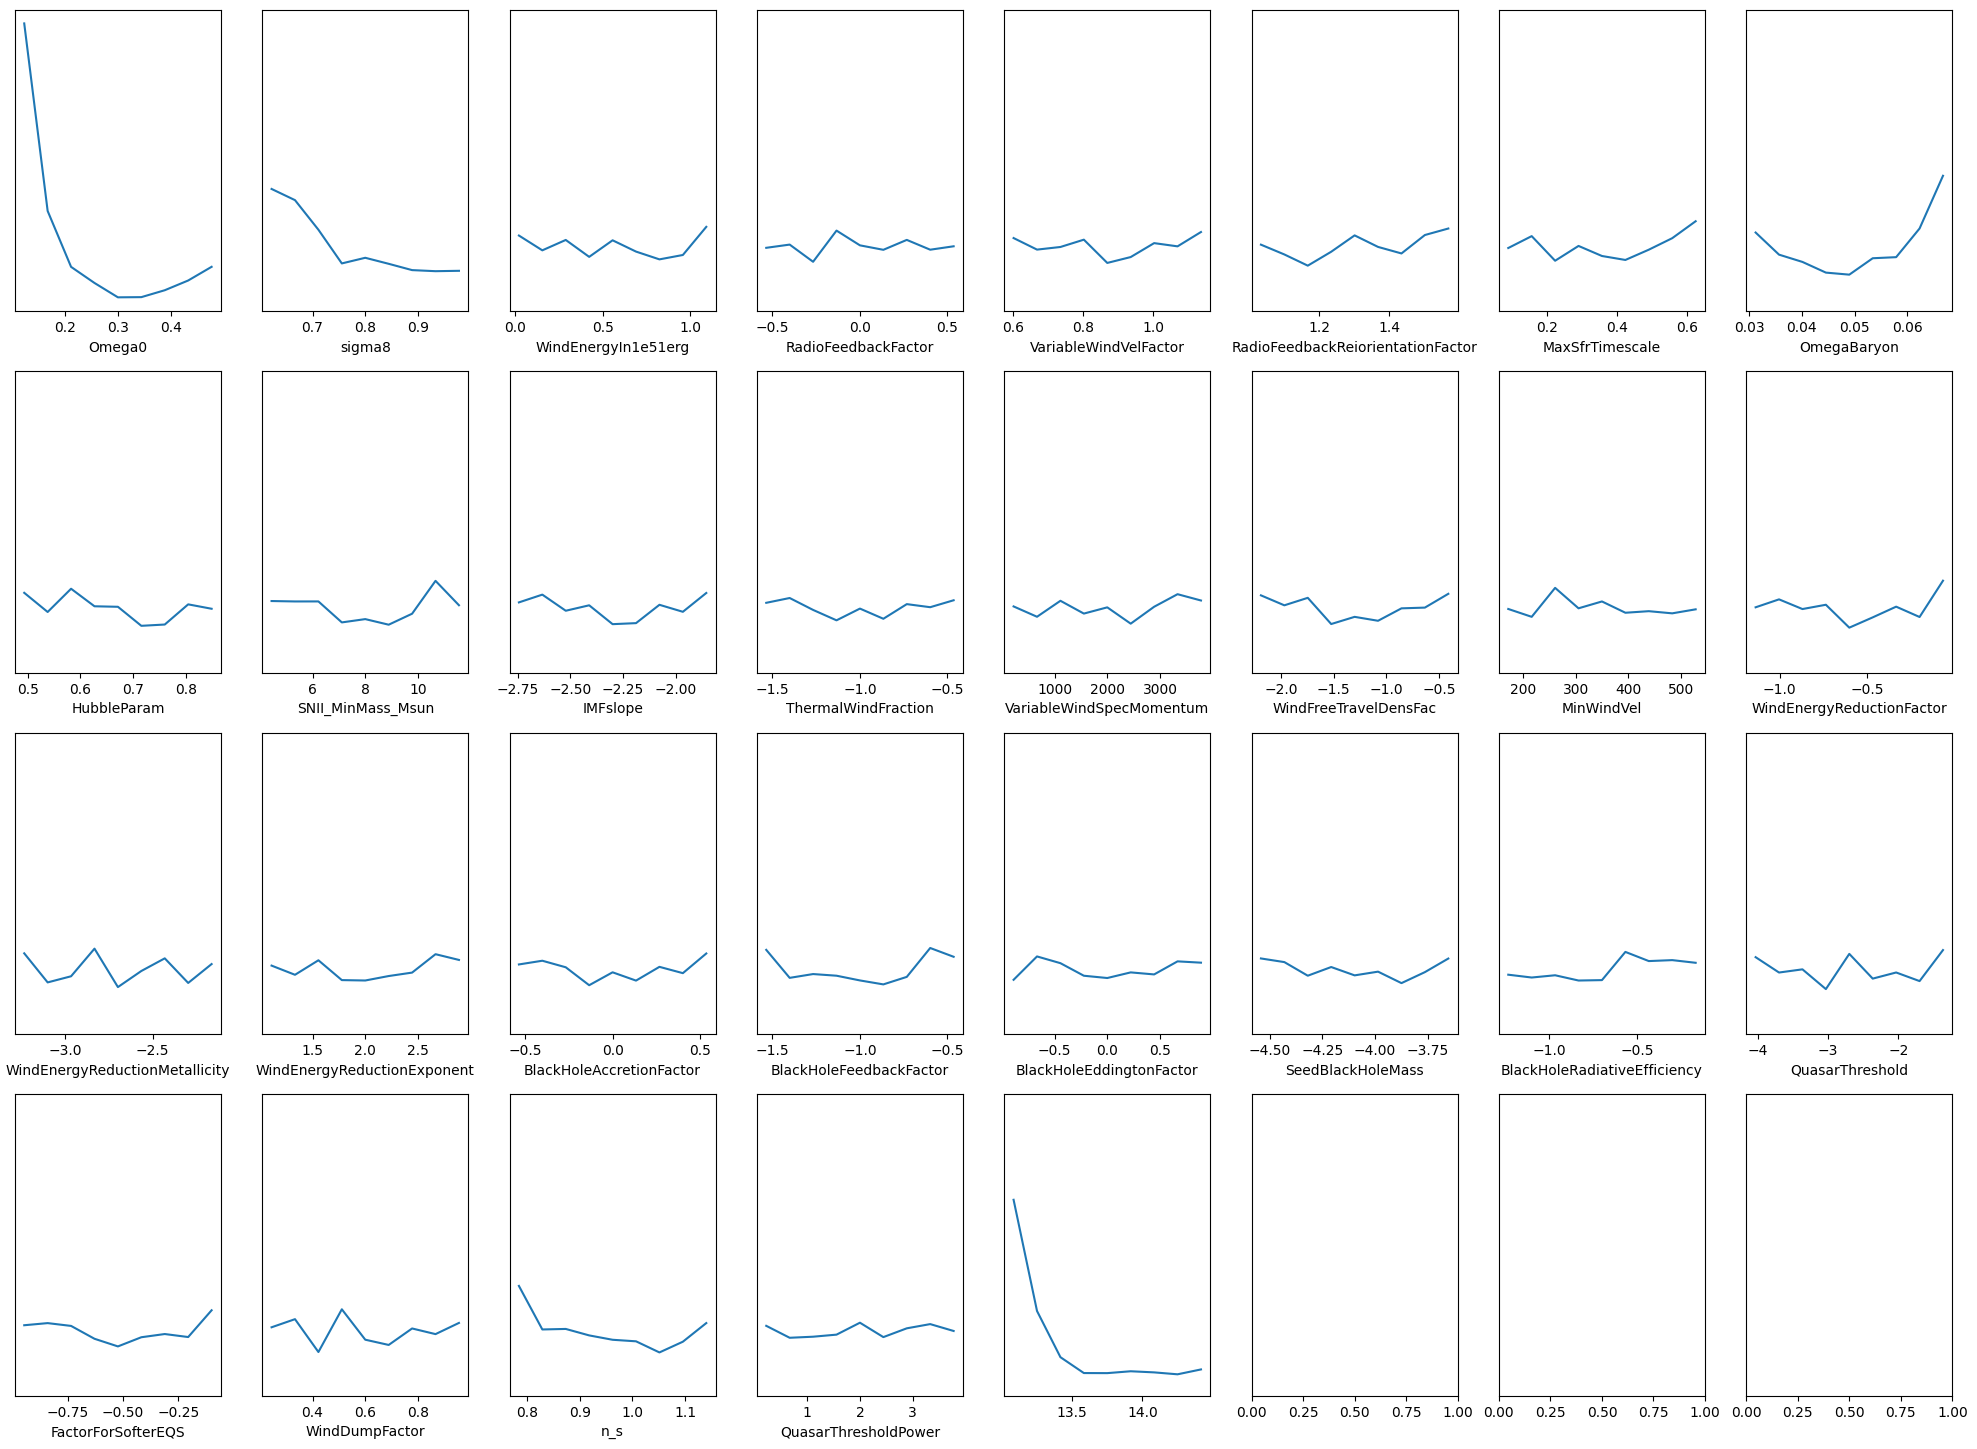

In [207]:
fig, axs = plt.subplots(ncols=8, nrows=4, figsize=(25, 18), sharey=True)
# fig.supxlabel(r'SB28 $Y_{SZ}$')
# fig.supylabel(r'Predicted $Y_{SZ}$')

for i in range(32):
    if i<29:
        if i <28:       
            if params_['LogFlag'][i] == 1:
                p = np.log10(params[:, i])
            else:
                p = params[:, i]
            stat = binned_statistic(p, np.diag(VCP), statistic='mean', bins=np.linspace(lbs[i], ubs[i], 10))
            bins = stat.bin_edges[1:] - 1/2 * np.mean(np.diff(stat.bin_edges))
            axs[i//8, i%8].plot(bins, stat.statistic, '-')
            axs[i//8, i%8].set_xlabel(params_['ParamName'][i])
            if i%8 != 0:
                axs[i//8, i%8].set_yticks([])
            # if i<24:
            #     axs[i//8, i%8].set_xticks([])
        else:
            stat = binned_statistic(Mass, np.diag(VCP), statistic='mean', bins=np.linspace(lbs[-1], ubs[-1], 10))
            bins = stat.bin_edges[1:] - 1/2 * np.mean(np.diff(stat.bin_edges))
            axs[i//8, i%8].plot(bins, stat.statistic, '-')
            axs[i//8, i%8].set_yticks([])


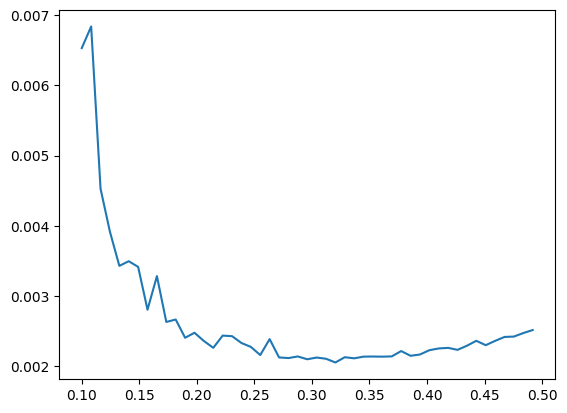

In [198]:
plt.plot(stat.bin_edges[:-1], stat.statistic)

In [225]:
next_thetas_real[:, -1]

array([13.76829334, 13.0663753 , 14.83248295, 13.31353405, 13.08286202,
       14.65432576, 13.68309328, 14.22348139, 14.75031397, 13.38916194,
       13.89116342, 13.39982914, 13.80616374, 13.08134919, 14.74614893,
       14.10681605, 13.22888822, 14.21342758, 14.72148189, 13.34053324,
       14.24998692, 14.46470014, 13.93178012, 13.32031578, 13.488765  ,
       13.12147397, 14.51850164, 13.2531302 , 13.08752961, 13.73079983,
       14.42256198, 13.76405618, 14.12102514, 13.92502109, 13.1178447 ,
       13.19129997, 14.48019344, 14.51601565, 14.58489332, 13.07620704,
       13.24003825, 14.11524546, 14.00501296, 14.17156352, 14.12597226,
       13.46735857, 13.28106411, 13.31347633, 14.08894473, 13.73599722,
       13.77689222, 13.92495057, 13.29065476, 13.90324876, 13.47656573,
       14.16741419, 14.47332443, 13.13811517, 13.18093036, 13.33962186,
       14.68146448, 13.6038443 , 14.55081415, 13.46655173, 14.3430147 ,
       14.32069312, 14.41425889, 14.48149766, 14.29190723, 13.92

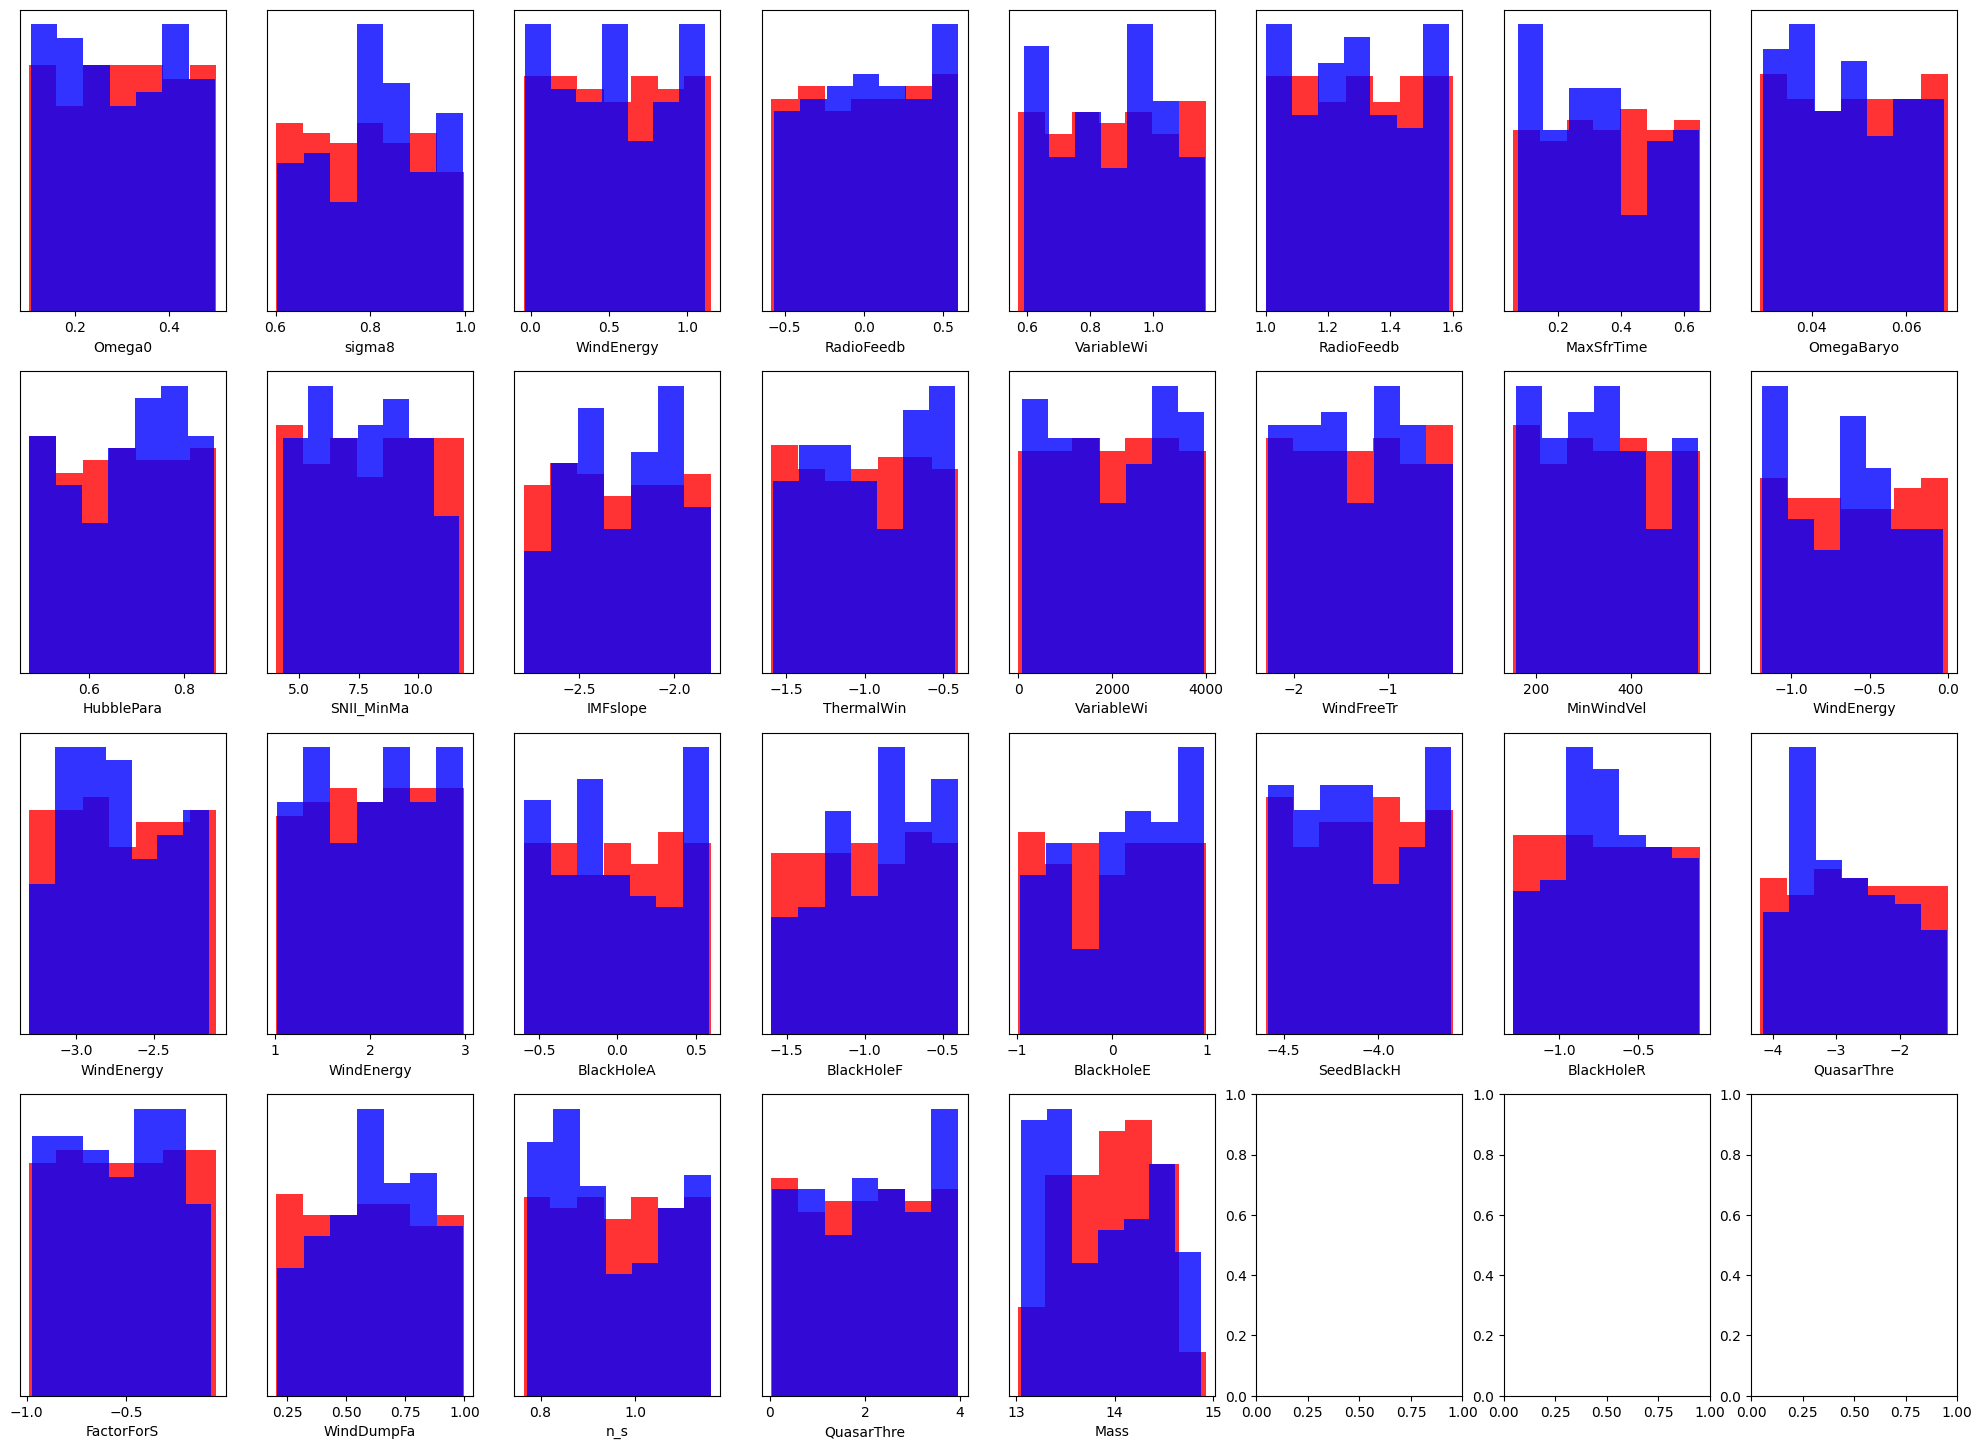

In [224]:
fig, axs = plt.subplots(ncols=8, nrows=4, figsize=(25, 18))
for i in range(32):
    if i<29:
        if i<28:
            axs[i//8, i%8].hist(theta_[:, i], color='r', alpha=0.8, bins=7)

            axs[i//8, i%8].hist(next_thetas_real[:, i], color='b', alpha=0.8, bins=7)
            axs[i//8, i%8].set_yticks([])
            axs[i//8, i%8].set_xlabel(df.loc[i, 'ParamName'][:10])

        else:
            axs[i//8, i%8].hist(theta_[:, i], color='r', alpha=0.8, bins=7)
            axs[i//8, i%8].hist(next_thetas_real[:, i], color='b', alpha=0.8, bins=7)
            axs[i//8, i%8].set_yticks([])
            axs[i//8, i%8].set_xlabel('Mass')
        axs[i//8, i%8].set_yticks([])



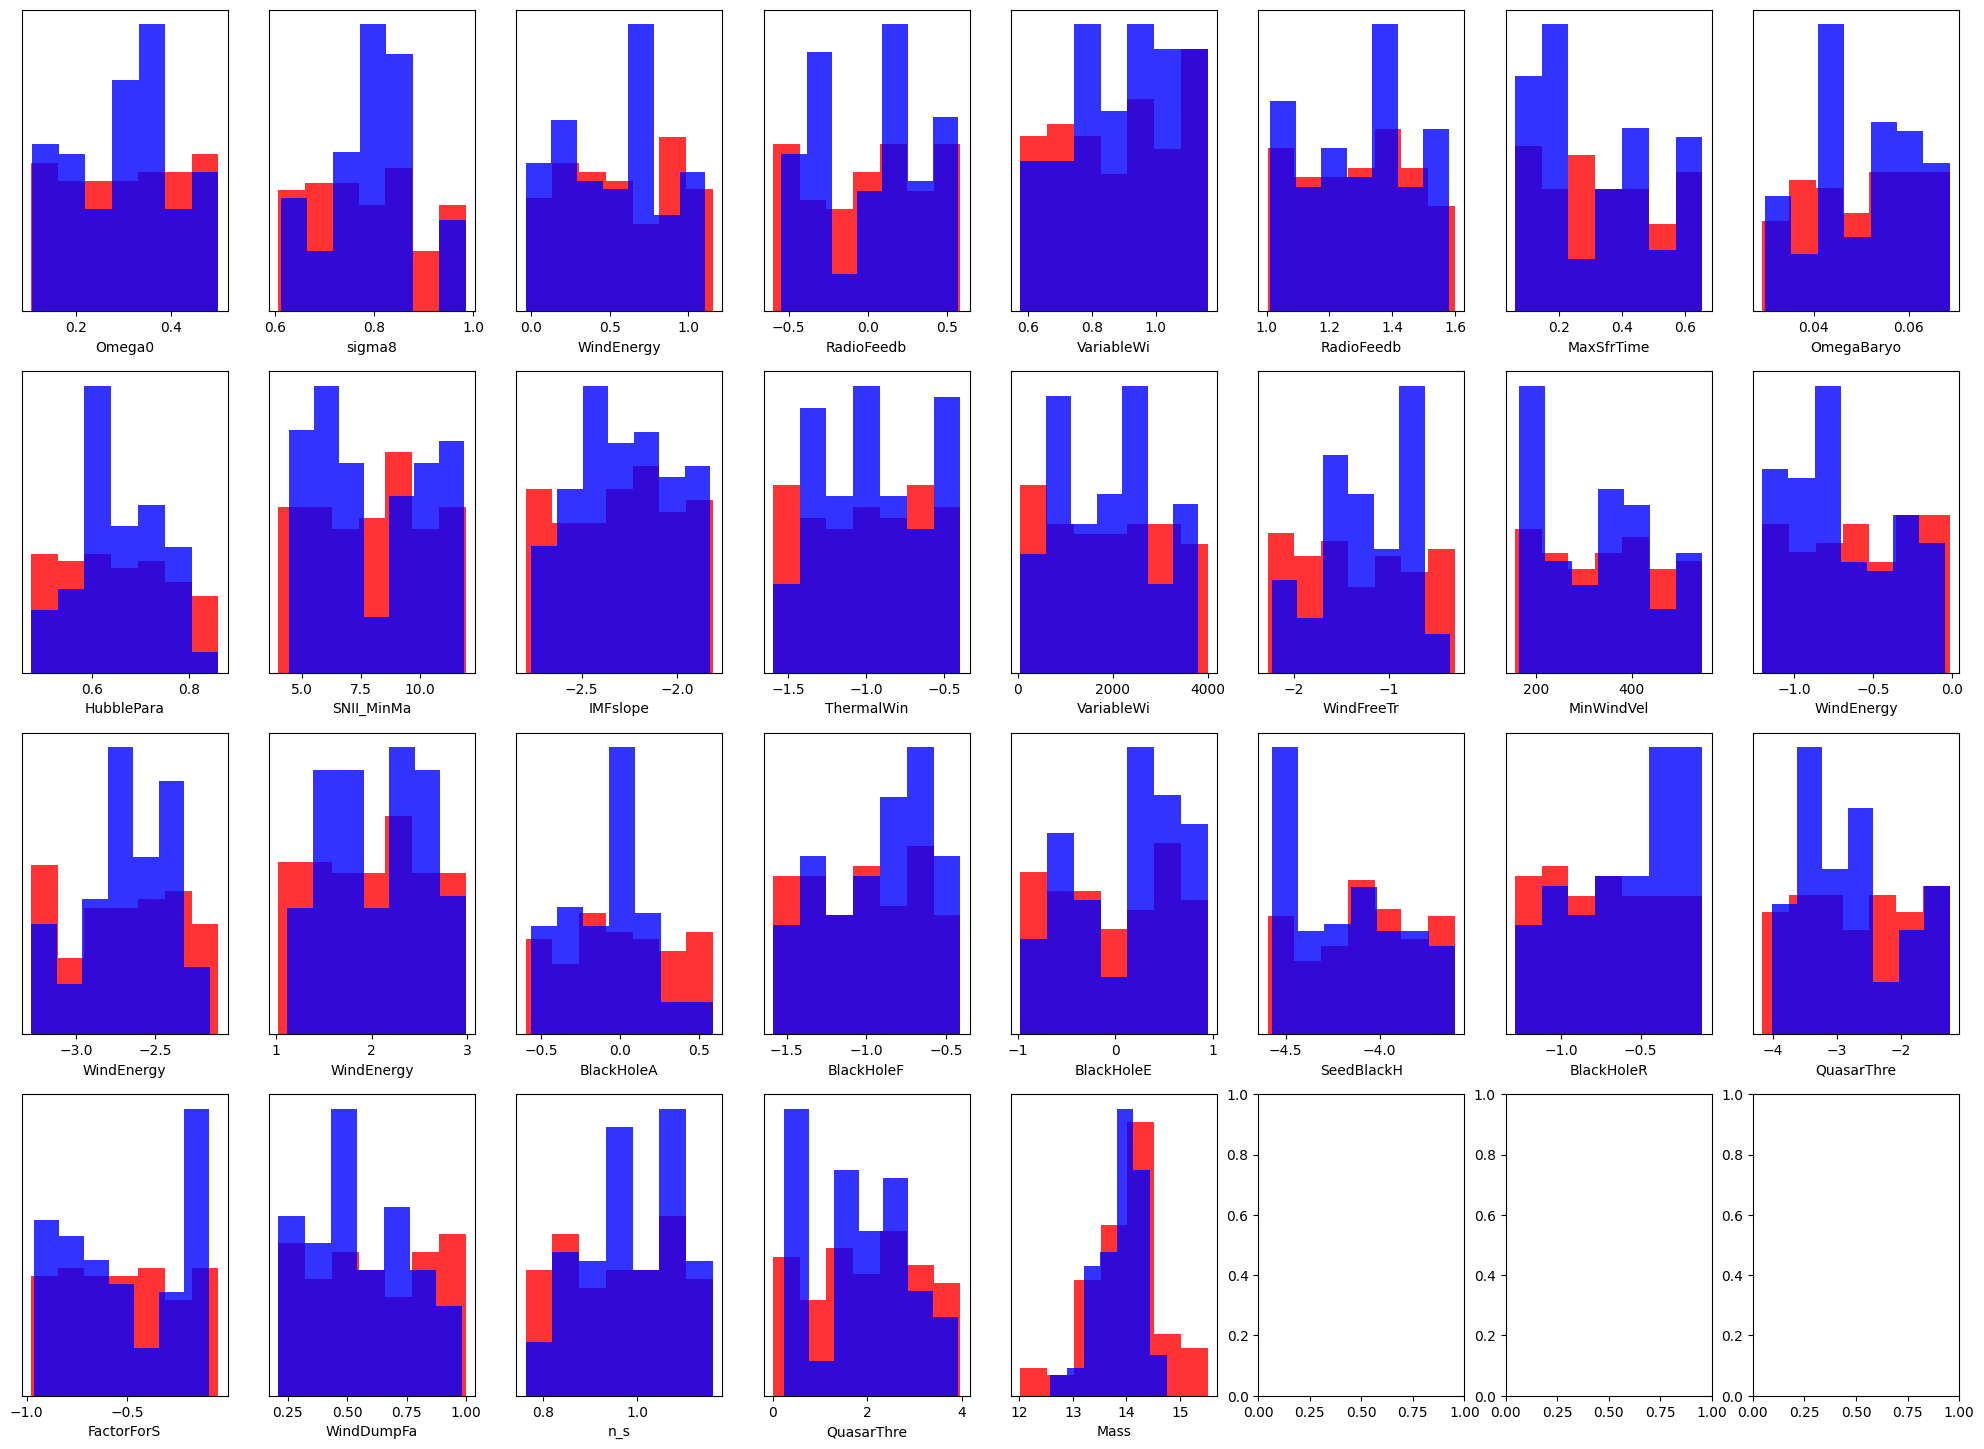

In [167]:
fig, axs = plt.subplots(ncols=8, nrows=4, figsize=(25, 18))
for i in range(32):
    if i<29:
        if i<28:
            axs[i//8, i%8].hist(theta_R_[:, i], color='r', alpha=0.8, bins=7)

            axs[i//8, i%8].hist(next_surrogates_real[:, i], color='b', alpha=0.8, bins=7)
            axs[i//8, i%8].set_yticks([])
            axs[i//8, i%8].set_xlabel(df.loc[i, 'ParamName'][:10])

        else:
            axs[i//8, i%8].hist(theta_R_[:, i], color='r', alpha=0.8, bins=7)
            axs[i//8, i%8].hist(next_surrogates_real[:, i], color='b', alpha=0.8, bins=7)
            axs[i//8, i%8].set_yticks([])
            axs[i//8, i%8].set_xlabel('Mass')
        axs[i//8, i%8].set_yticks([])


In [306]:
# import pickle
# outfile = open('emu_1p_2', 'wb')
# pickle.dump(emu, outfile)
# outfile.close()

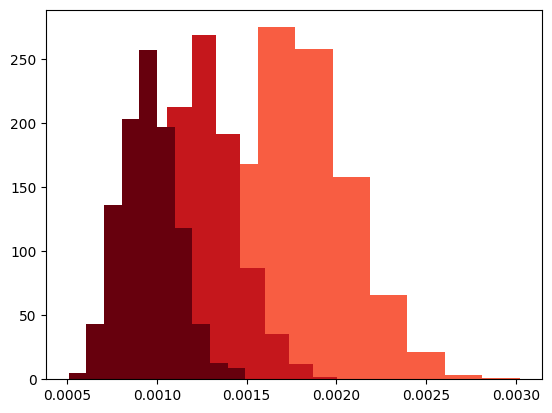

In [307]:
cs = plt.cm.Reds(np.linspace(0.3, 1, len(pred_tests)))
M= uncorr_gp.predict(Y_mean, multitesttheta)
for i in range(1, 4):
    var = np.diag(pred_vars[i]).flatten()
    plt.hist(var, color=cs[i], alpha=1, bins=10, log=False)
    

-5.243700572333901
-11.623004900543886
-7.623443999730769


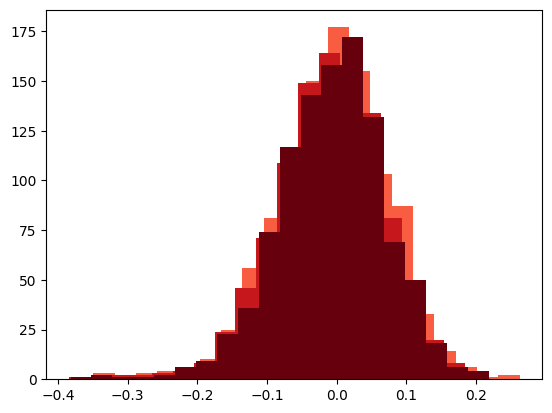

In [308]:
cs = plt.cm.Reds(np.linspace(0.3, 1, len(pred_tests)))
M= uncorr_gp.predict(Y_mean, multitesttheta)
for i in range(1, 4):
    var = (M - pred_tests[i])#/np.diag(pred_vars[i])
    plt.hist(var, color=cs[i], alpha=1, bins=20)
    print(np.sum(var))

# Looking at pretrained network

In [19]:
import pickle

In [20]:
params = {"log_scaleV"   :7*np.ones(emuCP.param_dimensions),
        "log_scaleX" :7*np.ones(emuCP.param_dimensions),
        "log_scaleW" : 7*np.ones(emuCP.param_dimensions),
        "log_scaleM" :7*np.ones(emuCP.param_dimensions),
        "log_ampV"   :0.5*np.ones(emuCP.param_dimensions),
        "log_ampW"   :0.3*np.ones(emuCP.param_dimensions),
        "log_ampX"   :-1.*np.ones(emuCP.param_dimensions),                
        "log_deltaP" :0*np.ones(emuCP.param_dimensions),
        "log_jitterV":-2.0,
        "log_jitterW":-2.0,
        "log_mean"   :-1.0}

In [188]:
file = open('emu_1p_2', 'rb')
emu = pickle.load(file)
file.close()

First lets look at if this worked at all. We need to rerun the training but thats ok

In [22]:
M, V = emu.predict(multitesttheta)

In [23]:
# Create simulation objects and surrogate objects
sims  = CARPoolSimulations.Simulation()
surrs = CARPoolSimulations.Simulation()

# Set the parameters and quantities for these simulations
sims.parameters  = emu.Simulations.parameters[:128]
sims.quantities=emu.Simulations.quantities[:128]
surrs.parameters = emu.Surrogates.parameters[:128]
surrs.quantities=emu.Surrogates.quantities[:128]

# Generate an emulator and train
emu0 = CARPoolEmulator.Emulator(sims, surrs)
best_params0 = emu0.train(params, learning_rate=1e-3, max_iterations=500)

In [24]:
# Create simulation objects and surrogate objects
sims  = CARPoolSimulations.Simulation()
surrs = CARPoolSimulations.Simulation()

# Set the parameters and quantities for these simulations
sims.parameters  = emu.Simulations.parameters[:256]
sims.quantities=emu.Simulations.quantities[:256]
surrs.parameters = emu.Surrogates.parameters[:256]
surrs.quantities=emu.Surrogates.quantities[:256]

# Generate an emulator and train
emu1 = CARPoolEmulator.Emulator(sims, surrs)
best_params1 = emu1.train(params, learning_rate=1e-3, max_iterations=500)

In [25]:
# Create simulation objects and surrogate objects
sims  = CARPoolSimulations.Simulation()
surrs = CARPoolSimulations.Simulation()

# Set the parameters and quantities for these simulations
sims.parameters  = emu.Simulations.parameters[:384]
sims.quantities=emu.Simulations.quantities[:384]
surrs.parameters = emu.Surrogates.parameters[:384]
surrs.quantities=emu.Surrogates.quantities[:384]

# Generate an emulator and train
emu2 = CARPoolEmulator.Emulator(sims, surrs)
best_params2 = emu2.train(params, learning_rate=1e-3, max_iterations=500)

In [26]:
# Create simulation objects and surrogate objects
sims  = CARPoolSimulations.Simulation()
surrs = CARPoolSimulations.Simulation()

# Set the parameters and quantities for these simulations
sims.parameters  = emu.Simulations.parameters
sims.quantities=emu.Simulations.quantities
surrs.parameters = emu.Surrogates.parameters
surrs.quantities=emu.Surrogates.quantities

# Generate an emulator and train
emu3 = CARPoolEmulator.Emulator(sims, surrs)
best_params3 = emu3.train(params, learning_rate=1e-3, max_iterations=500)

## Testing on the 1P model, how well do we do

In [27]:
emus = [emu0, emu1, emu2, emu3]
Ms, Vs  = [], []
for em in emus:
    # Predict the 1P set
    M, V = em.predict(test_theta)
    Ms.append(M)
    Vs.append(V)

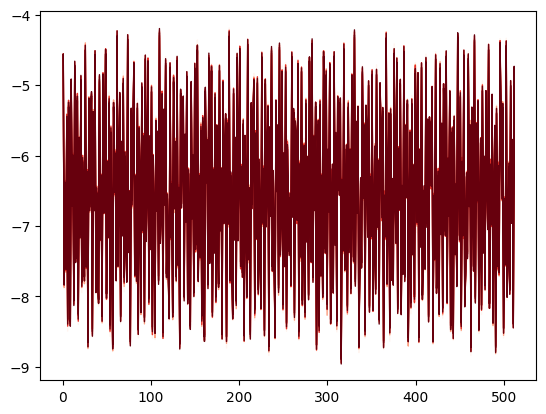

In [32]:
cs = plt.cm.Reds(np.linspace(0, 1, 4))
for M, V, c in zip(Ms, Vs, cs):
    plt.fill_between(np.arange(len(M)), M -np.sqrt(np.diag(V)), M+np.sqrt(np.diag(V)), color=c)

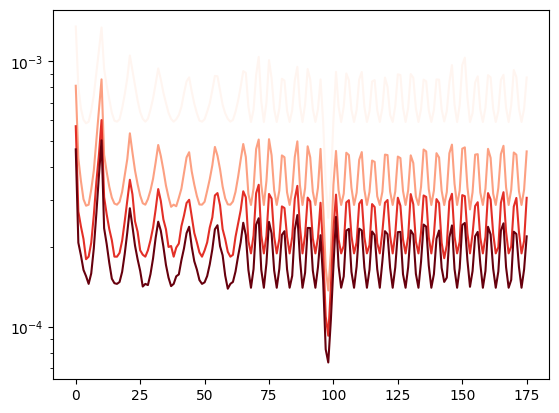

In [64]:
for v, c in zip(Vs, cs):
    plt.semilogy(np.diag(v), c=c)

Text(0, 0.5, 'Variance reduction [$\\sigma_0/\\sigma_n$]')

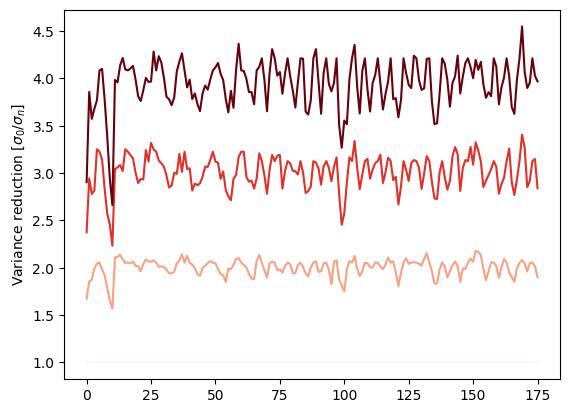

In [65]:
for v, c in zip(Vs, cs):
    plt.plot(np.diag(Vs[0]) / np.diag(v), c=c)
plt.ylabel('Variance reduction [$\sigma_0/\sigma_n$]')

It looks like we get a factor of ~3.5 better variance reduction here. Can we compare this to just a regular gaussian process?

In [113]:
params = {"log_scaleV"   :3*np.ones(emuCP.param_dimensions),
        "log_scaleX" :0*np.ones(emuCP.param_dimensions),
        "log_scaleW" : 3*np.ones(emuCP.param_dimensions),
        "log_scaleM" :0*np.ones(emuCP.param_dimensions),
        "log_ampV"   :0.5*np.ones(emuCP.param_dimensions),
        "log_ampW"   :0.3*np.ones(emuCP.param_dimensions),
        "log_ampX"   :0.*np.ones(emuCP.param_dimensions),                
        "log_deltaP" :0*np.ones(emuCP.param_dimensions),
        "log_jitterV":-2.0,
        "log_jitterW":-2.0,
        "log_mean"   :-1.0}
theta_reg = generate_theta(param_df, N=10, d=29, seed=31)
data_reg, _  = generate_model(theta_reg, uncorr_gp=uncorr_gp, Y_mean=Y_mean, seed=192, sigma=sigma )
# Create simulation objects and surrogate objects
sims  = CARPoolSimulations.Simulation()
surrs = CARPoolSimulations.Simulation()

# Set the parameters and quantities for these simulations
sims.parameters  = theta_reg[:512]
sims.quantities  =  data_reg[:512]
surrs.parameters = theta_reg[512:]
surrs.quantities=data_reg[512:]

# Generate an emulator and train
emu_reg = CARPoolEmulator.Emulator(sims, surrs)
best_params_reg = emu_reg.train(params, learning_rate=1e-3, max_iterations=50)

In [114]:
Mreg, Vreg = emu_reg.predict(test_theta)
MCP, VCP = emuCP.predict(test_theta)

ValueError: operands could not be broadcast together with shapes (512,) (176,) 

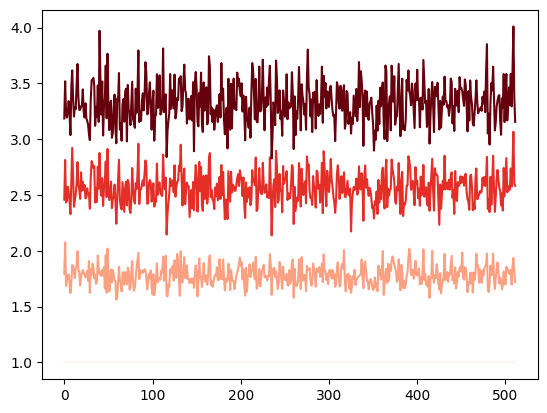

In [115]:
for v, c in zip(Vs, cs):
    plt.plot(np.diag(Vs[0]) / np.diag(v), c=c)

plt.plot( np.diag(Vs[0]) /np.diag(Vreg), c='k', ls=':')
plt.plot( np.diag(Vs[0]) /np.diag(VCP), c='k', ls='--')

plt.ylabel('Variance reduction [$\sigma_0/\sigma_n$]')

# Now more thetas?

Text(0, 0.5, 'N')

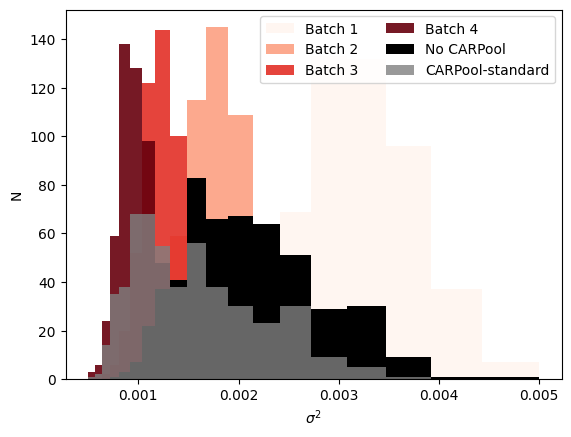

In [116]:
emus = [emu0, emu1, emu2, emu3]
Ms, Vs  = [], []
for em in emus:
    # Predict the 1P set
    M, V = em.predict(multitesttheta)
    Ms.append(M)
    Vs.append(V)
Mreg, Vreg = emu_reg.predict(multitesttheta)
MCP, VCP = emuCP.predict(multitesttheta)

plt.figure()
for v, c, i in zip(Vs, cs, np.arange(4)):
    plt.hist(np.diag(v), color=c, alpha=0.9, bins=np.logspace(np.log10(0.0005), np.log10(0.005), 20), label='Batch %i'%(i+1))
_ = plt.hist(np.diag(Vreg), color='k', alpha=1, bins=np.logspace(np.log10(0.0005), np.log10(0.005), 20), label='No CARPool')
_ = plt.hist(np.diag(VCP), color='grey', alpha=0.8, bins=np.logspace(np.log10(0.0005), np.log10(0.005), 20), label='CARPool-standard')


plt.legend(ncols=2)

plt.xlabel('$\sigma^2$')
plt.ylabel('N')

# Predicting on a different dataset?

In [118]:
data = np.load('Data/first_1_SB28.npz')
S_mean = np.log10(data['S'][usable_data, 0])
uncorr_gp = train_gp(29, build_gp_uncorr, X, S_mean)

In [162]:
sigma = np.sqrt(uncorr_gp.noise.diag[0])

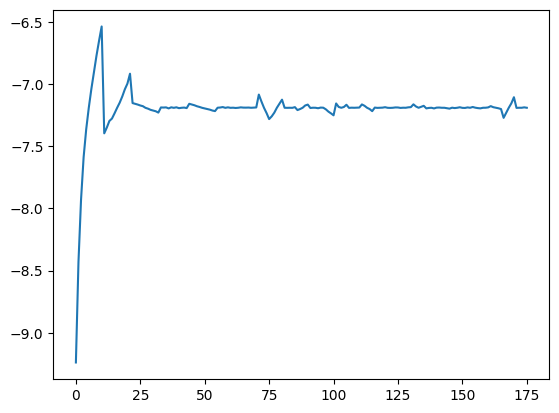

In [163]:
plt.plot(uncorr_gp.predict(S_mean,test_theta ))

In [189]:
params = {"log_scaleV"   :7*np.ones(emuCP.param_dimensions),
        "log_scaleX" :7*np.ones(emuCP.param_dimensions),
        "log_scaleW" : 7*np.ones(emuCP.param_dimensions),
        "log_scaleM" :7*np.ones(emuCP.param_dimensions),
        "log_ampV"   :0.5*np.ones(emuCP.param_dimensions),
        "log_ampW"   :0.3*np.ones(emuCP.param_dimensions),
        "log_ampX"   :-1.*np.ones(emuCP.param_dimensions),                
        "log_deltaP" :0*np.ones(emuCP.param_dimensions),
        "log_jitterV":-2.0,
        "log_jitterW":-2.0,
        "log_mean"   :-1.0}

In [184]:
sigma

0.20320948979121678

In [165]:
# Create simulation objects and surrogate objects
sims  = CARPoolSimulations.Simulation()
surrs = CARPoolSimulations.Simulation()

# Set the parameters and quantities for these simulations
sims.parameters  = emu.Simulations.parameters[:128]
data, intrinsic_noise  = generate_model(emu.Simulations.parameters[:128], uncorr_gp, S_mean, sigma=sigma)
sims.quantities = data
surrs.parameters = emu.Surrogates.parameters[:128]
surrs.quantities = uncorr_gp.predict(S_mean, surrs.parameters[:128]) + intrinsic_noise

# Generate an emulator and train
emuS0 = CARPoolEmulator.Emulator(sims, surrs)
best_paramsS0 = emuS0.train(params, learning_rate=1e-3, max_iterations=500)

In [166]:
# Create simulation objects and surrogate objects
sims  = CARPoolSimulations.Simulation()
surrs = CARPoolSimulations.Simulation()

# Set the parameters and quantities for these simulations
sims.parameters  = emu.Simulations.parameters[:256]
data, intrinsic_noise  = generate_model(emu.Simulations.parameters[:256], uncorr_gp, S_mean, sigma=sigma)
sims.quantities = data
surrs.parameters = emu.Surrogates.parameters[:256]
surrs.quantities = uncorr_gp.predict(S_mean, surrs.parameters[:256]) + intrinsic_noise

# Generate an emulator and train
emuS1 = CARPoolEmulator.Emulator(sims, surrs)
best_paramsS1 = emuS1.train(params, learning_rate=1e-3, max_iterations=500)

In [167]:
# Create simulation objects and surrogate objects
sims  = CARPoolSimulations.Simulation()
surrs = CARPoolSimulations.Simulation()

# Set the parameters and quantities for these simulations
sims.parameters  = emu.Simulations.parameters[:384]
data, intrinsic_noise  = generate_model(emu.Simulations.parameters[:384], uncorr_gp, S_mean, sigma=sigma)
sims.quantities = data
surrs.parameters = emu.Surrogates.parameters[:384]
surrs.quantities = uncorr_gp.predict(S_mean, surrs.parameters[:384]) + intrinsic_noise

# Generate an emulator and train
emuS2 = CARPoolEmulator.Emulator(sims, surrs)
best_paramsS2 = emuS2.train(params, learning_rate=1e-3, max_iterations=500)

In [201]:
# Create simulation objects and surrogate objects
sims  = CARPoolSimulations.Simulation()
surrs = CARPoolSimulations.Simulation()

# Set the parameters and quantities for these simulations
sims.parameters  = emu.Simulations.parameters
data, intrinsic_noise  = generate_model(emu.Simulations.parameters, uncorr_gp, S_mean, sigma=sigma)
sims.quantities = data
surrs.parameters = emu.Surrogates.parameters
surrs.quantities = uncorr_gp.predict(S_mean, surrs.parameters) + intrinsic_noise

# Generate an emulator and train
emuS3 = CARPoolEmulator.Emulator(sims, surrs)
best_paramsS3 = emuS3.train(params, learning_rate=1e-3, max_iterations=200)

In [169]:
params = {"log_scaleV"   :7*np.ones(emu.param_dimensions),
        "log_scaleX" :7*np.ones(emu.param_dimensions),
        "log_scaleW" : 7*np.ones(emu.param_dimensions),
        "log_scaleM" :7*np.ones(emu.param_dimensions),
        "log_ampV"   :0.5*np.ones(emu.param_dimensions),
        "log_ampW"   :0.3*np.ones(emu.param_dimensions),
        "log_ampX"   :-1.*np.ones(emu.param_dimensions),                
        "log_deltaP" :0*np.ones(emu.param_dimensions),
        "log_jitterV":-2.0,
        "log_jitterW":-2.0,
        "log_mean"   :-1.0}
theta_reg = generate_theta(param_df, N=10, d=29, seed=31)
data_reg, _  = generate_model(theta_reg, uncorr_gp=uncorr_gp, Y_mean=S_mean, seed=192, sigma=sigma)
# Create simulation objects and surrogate objects
sims  = CARPoolSimulations.Simulation()
surrs = CARPoolSimulations.Simulation()

# Set the parameters and quantities for these simulations
sims.parameters  = theta_reg[:512]
sims.quantities  =  data_reg[:512]
surrs.parameters = theta_reg[512:]
surrs.quantities=data_reg[512:]

# Generate an emulator and train
emu_regS = CARPoolEmulator.Emulator(sims, surrs)
best_params_regS = emu_regS.train(params, learning_rate=1e-3, max_iterations=50)

In [147]:
np.sqrt(np.median(uncorr_gp.noise.diag))

0.20320948979121678

In [170]:
params = {"log_scaleV"   :3*np.ones(emu.param_dimensions),
        "log_scaleX" :3*np.ones(emu.param_dimensions),
        "log_scaleW" : 3*np.ones(emu.param_dimensions),
        "log_scaleM" :3*np.ones(emu.param_dimensions),
        "log_ampV"   :0.5*np.ones(emu.param_dimensions),
        "log_ampW"   :0.3*np.ones(emu.param_dimensions),
        "log_ampX"   :-1.*np.ones(emu.param_dimensions),                
        "log_deltaP" :0*np.ones(emu.param_dimensions),
        "log_jitterV":-2.0,
        "log_jitterW":-2.0,
        "log_mean"   :-1.0}
theta = generate_theta(param_df, N=9, seed=1993, d=29)
    
data, intrinsic_noise = generate_model(theta, 
                                       uncorr_gp, 
                                       Y_mean, 
                                       seed=1902, sigma=sigma)

# theta_R, surrogate_data, surrogate_raw = generate_surrogates(
#                                                 theta, 
#                                                 intrinsic_noise, 
#                                                 uncorr_gp,
#                                                 Y_mean, 
#                                                 Groups=50)
theta_R, surrogate_data, surrogate_raw = generate_surrogates(
                                                theta, 
                                                intrinsic_noise, 
                                                param_df,
                                                uncorr_gp,
                                                Y_mean)

sims  = CARPoolSimulations.Simulation()
surrs = CARPoolSimulations.Simulation()

# Set the parameters and quantities for these simulations
sims.parameters  = theta
sims.quantities  =  data
surrs.parameters = theta_R
surrs.quantities=surrogate_data

# Generate an emulator and train
emuCPS = CARPoolEmulator.Emulator(sims, surrs)
best_params_CPS = emuCPS.train(params, learning_rate=1e-3, max_iterations=50)

In [171]:
file = open('emu_1p_2S', 'rb')
emu_S = pickle.load(file)
file.close()

In [172]:
params = {"log_scaleV"   :7*np.ones(emuCP.param_dimensions),
        "log_scaleX" :7*np.ones(emuCP.param_dimensions),
        "log_scaleW" : 7*np.ones(emuCP.param_dimensions),
        "log_scaleM" :7*np.ones(emuCP.param_dimensions),
        "log_ampV"   :0.5*np.ones(emuCP.param_dimensions),
        "log_ampW"   :0.3*np.ones(emuCP.param_dimensions),
        "log_ampX"   :-1.*np.ones(emuCP.param_dimensions),                
        "log_deltaP" :0*np.ones(emuCP.param_dimensions),
        "log_jitterV":-2.0,
        "log_jitterW":-2.0,
        "log_mean"   :-1.0}
# Create simulation objects and surrogate objects
sims  = CARPoolSimulations.Simulation()
surrs = CARPoolSimulations.Simulation()

# Set the parameters and quantities for these simulations
sims.parameters  = emu_S.Simulations.parameters
sims.quantities = emu_S.Simulations.quantities
surrs.parameters = emu_S.Surrogates.parameters
surrs.quantities = emu_S.Surrogates.quantities

# Generate an emulator and train
emu_S = CARPoolEmulator.Emulator(sims, surrs)
best_params_emu_S = emu_S.train(params, learning_rate=1e-3, max_iterations=500)

In [202]:
emus = [emuS0, emuS1, emuS2, emuS3]
Ms, Vs  = [], []
for em in emus:
    # Predict the 1P set
    M, V = em.predict(test_theta)
    Ms.append(M)
    Vs.append(V)

Text(0, 0.5, 'Variance reduction [$\\sigma_0/\\sigma_n$]')

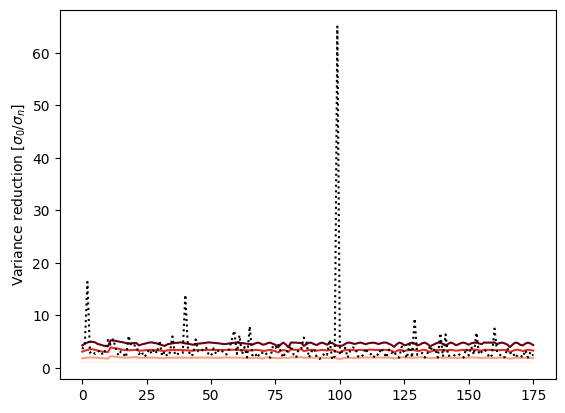

In [177]:
for v, c in zip(Vs, cs):
    plt.plot(np.diag(Vs[0]) / np.diag(v), c=c)
MsS, VsS = emu_regS.predict(test_theta)
plt.plot(np.diag(Vs[0]) / np.abs(np.diag(VsS)), c='k', ls=':')

plt.ylabel('Variance reduction [$\sigma_0/\sigma_n$]')

Text(0.5, 0, '$\\sigma^2_S$')

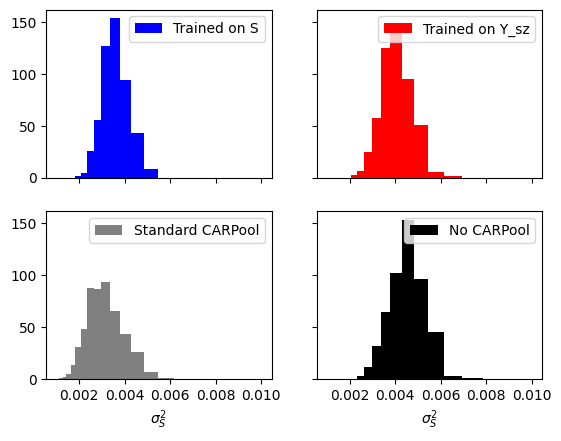

In [220]:
Ms, Vs  = [], []
for em in emus:
    # Predict the 1P set
    M, V = em.predict(multitesttheta)
    Ms.append(M)
    Vs.append(V)
Mreg, Vreg = emu_regS.predict(multitesttheta)
MCP, VCP = emuCPS.predict(multitesttheta)
MS, VS = emu_S.predict(multitesttheta)

fig, axs = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)
# for v, c, i in zip(Vs, cs, np.arange(4)):
_ = axs[0,0].hist(np.abs(np.diag(VS)), color='blue', alpha=1, label='Trained on S',  bins=np.logspace(np.log10(0.001), np.log10(0.01), 20))
_ = axs[0,1].hist(np.abs(np.diag(Vs[-1])), color='red', alpha=1, label='Trained on Y_sz',  bins=np.logspace(np.log10(0.001), np.log10(0.01), 20))
_ =axs[1,0].hist(np.abs(np.diag(VCP)), color='grey', alpha=1, label='Standard CARPool',  bins=np.logspace(np.log10(0.001), np.log10(0.01), 20))
_ = axs[1,1].hist(np.abs(np.diag(Vreg)), color='k', alpha=1, label='No CARPool', bins=np.logspace(np.log10(0.001), np.log10(0.01), 20))

axs[0,0].legend()
axs[0,1].legend()
axs[1,0].legend()
axs[1,1].legend()


axs[1,0].set_xlabel('$\sigma^2_S$')
axs[1,1].set_xlabel('$\sigma^2_S$')

# plt.ylabel('N')

In [248]:
emu.Simulations.parameters[:128].shape

(128, 29)

In [250]:
df = pd.read_csv('Data/SB28_param_minmax.csv')


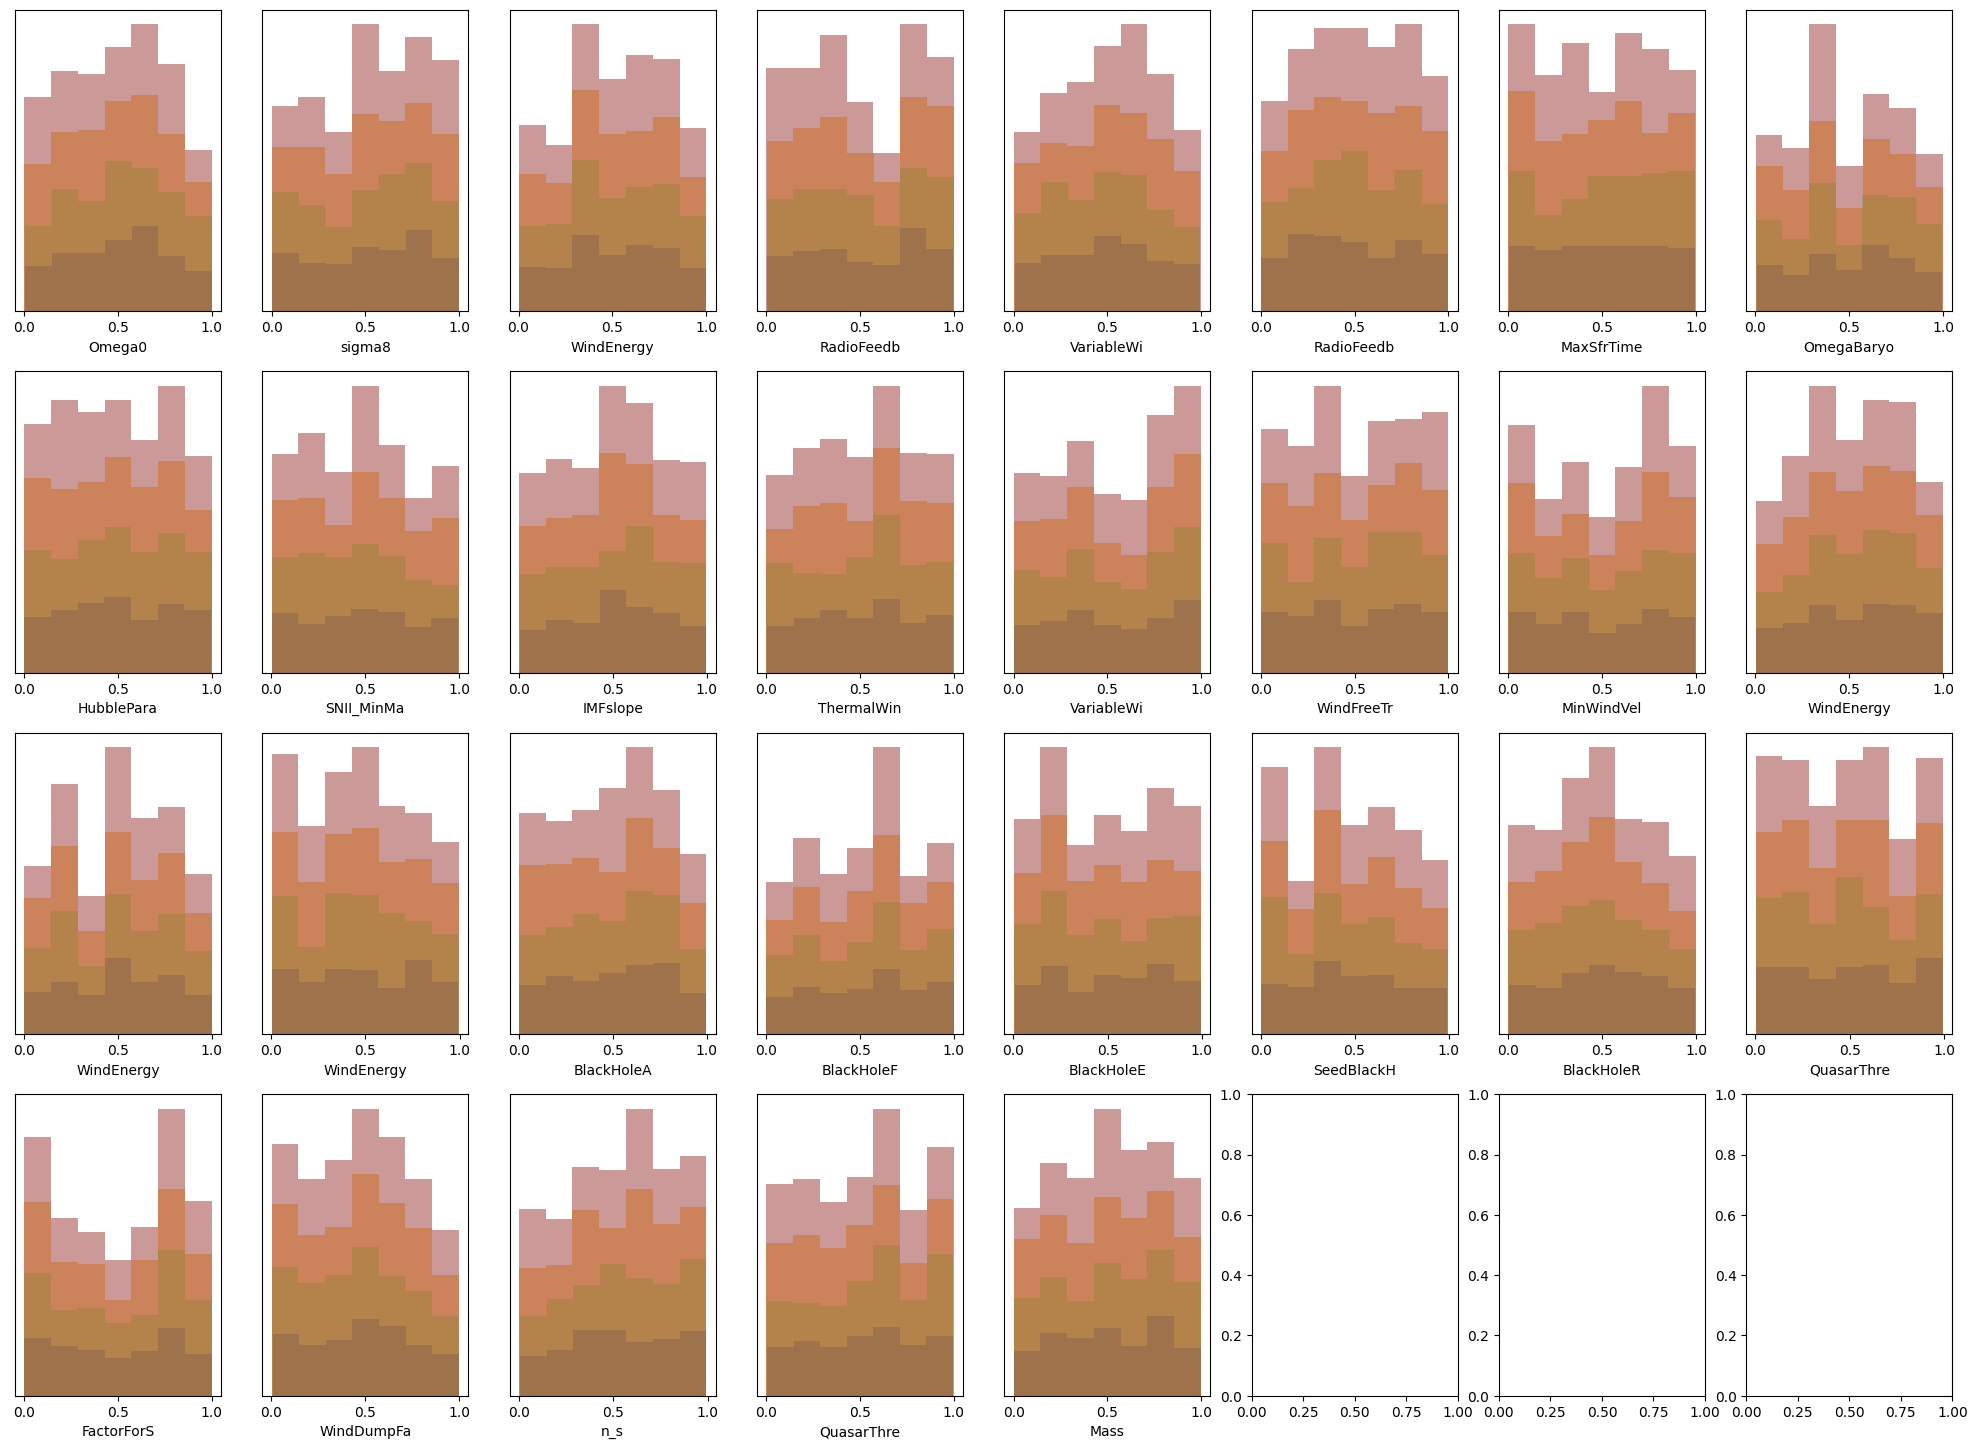

In [277]:
fig, axs = plt.subplots(ncols=8, nrows=4, figsize=(25, 18))
cs = plt.cm.jet(np.linspace(0.2, 1, 4))
for j in range(4):
    theta = np.concatenate((emu.Surrogates.parameters[:128*(j+1)], emu.Simulations.parameters[:128*(j+1)]))

    for i in range(32):
        if i<29:
            if i<28:
                axs[i//8, i%8].hist(theta[:, i], color=cs[j], alpha=0.4, bins=7)
                axs[i//8, i%8].set_yticks([])
                axs[i//8, i%8].set_xlabel(df.loc[i, 'ParamName'][:10])

            else:
                axs[i//8, i%8].hist(theta[:, i], color=cs[j], alpha=0.4, bins=7)
                axs[i//8, i%8].set_yticks([])
                axs[i//8, i%8].set_xlabel('Mass')
            axs[i//8, i%8].set_yticks([])


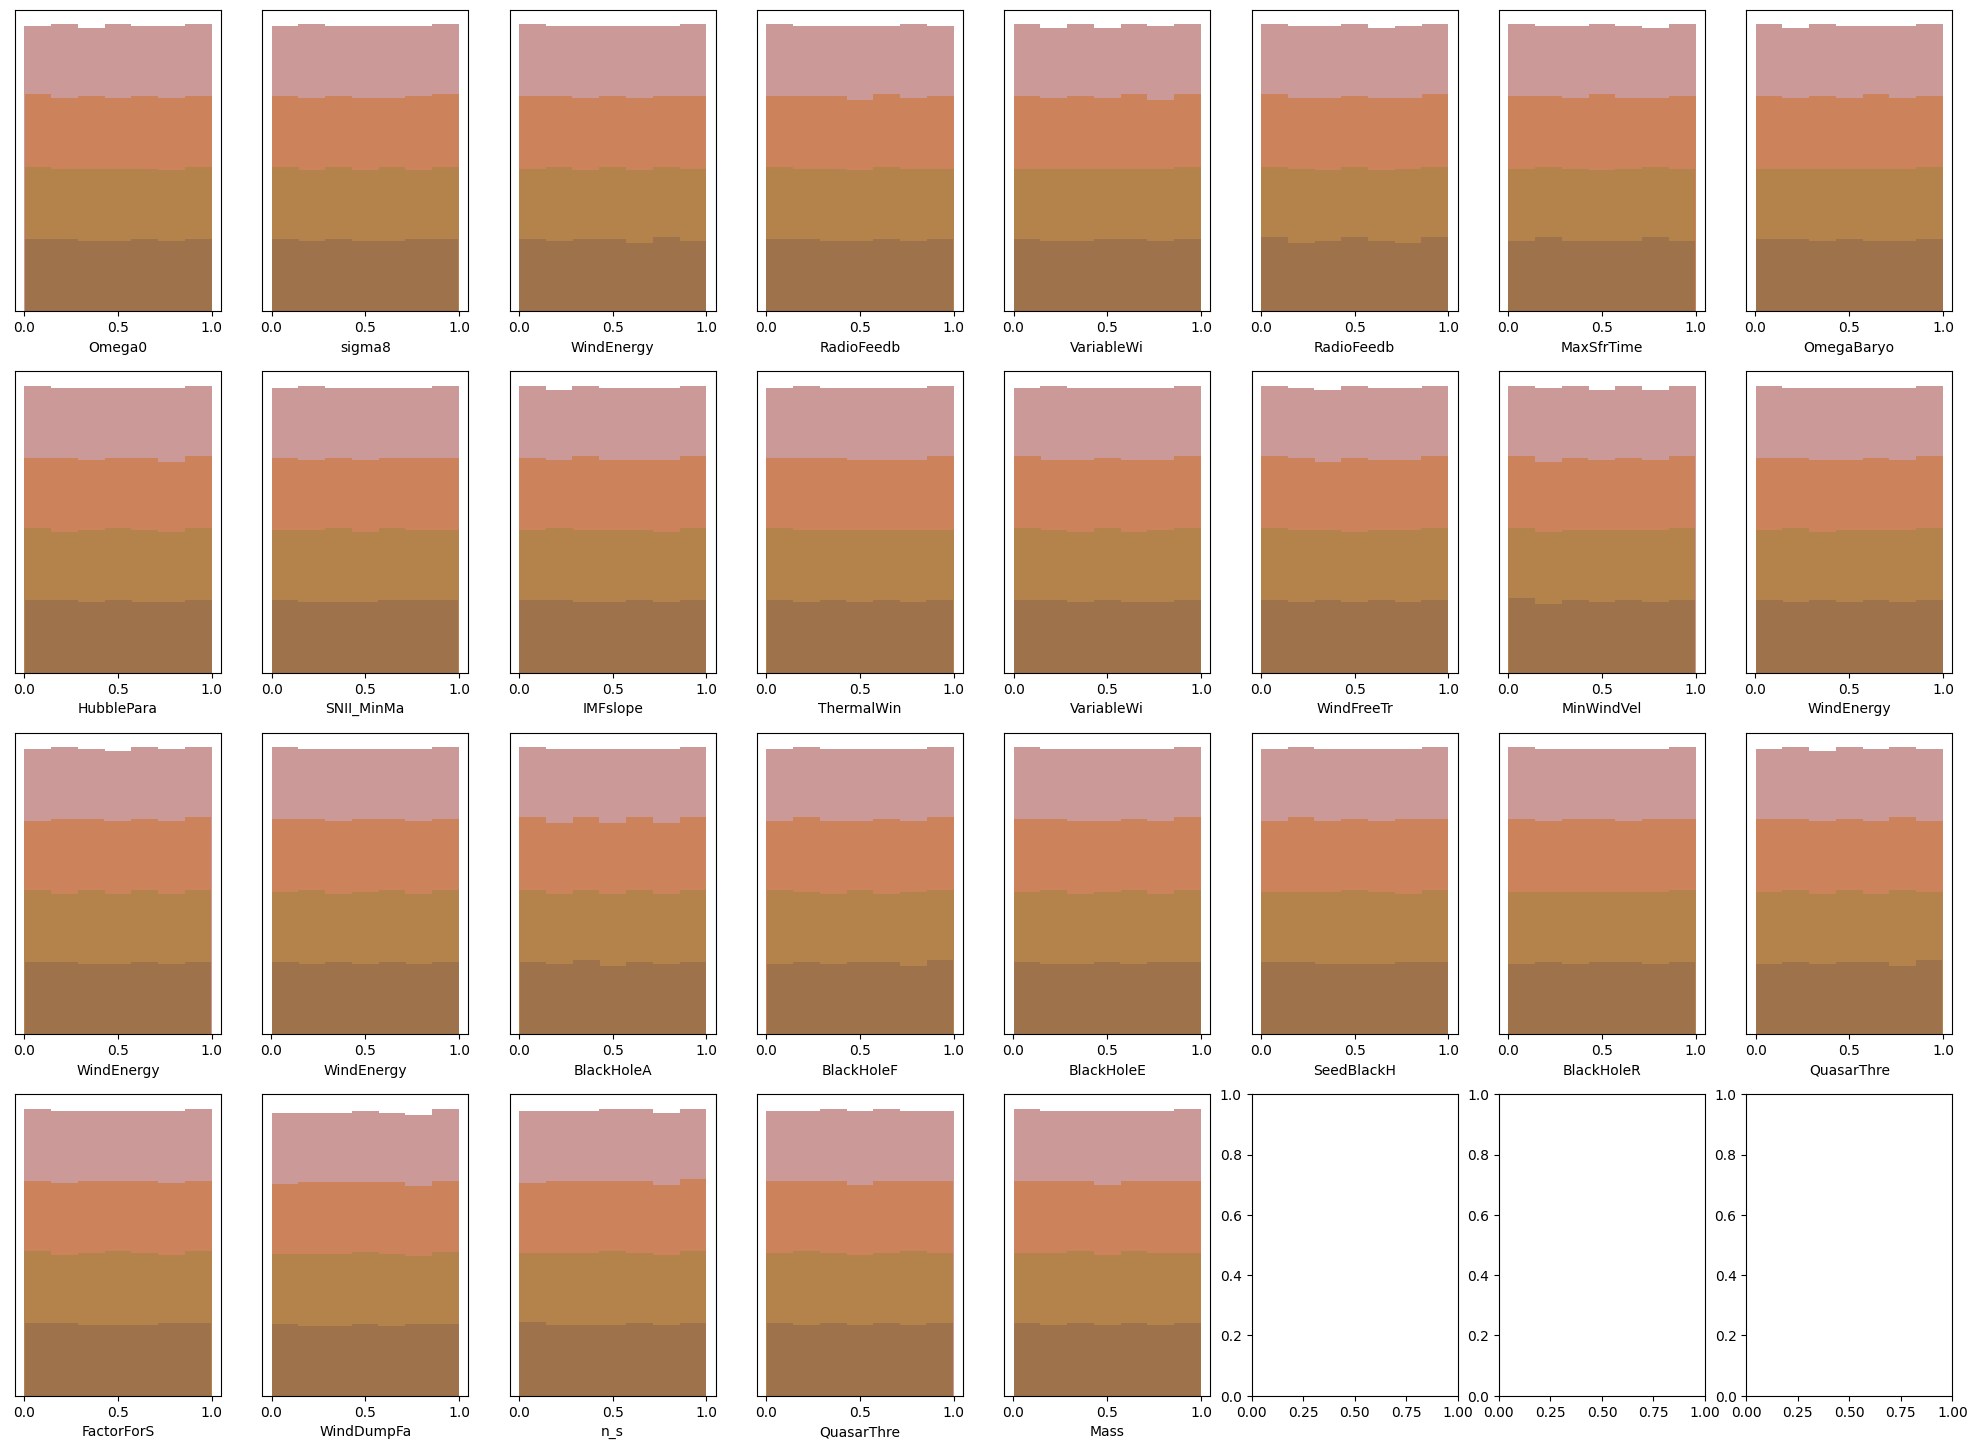

In [276]:
fig, axs = plt.subplots(ncols=8, nrows=4, figsize=(25, 18))
cs = plt.cm.jet(np.linspace(0.2, 1, 4))
for j in range(4):
    theta = theta_reg[:256*(j+1)]

    for i in range(32):
        if i<29:
            if i<28:
                axs[i//8, i%8].hist(theta[:, i], color=cs[j], alpha=0.4, bins=7)
                axs[i//8, i%8].set_yticks([])
                axs[i//8, i%8].set_xlabel(df.loc[i, 'ParamName'][:10])

            else:
                axs[i//8, i%8].hist(theta[:, i], color=cs[j], alpha=0.4, bins=7)
                axs[i//8, i%8].set_yticks([])
                axs[i//8, i%8].set_xlabel('Mass')
            axs[i//8, i%8].set_yticks([])


In [100]:
theta_file = np.load('next_params.npz')

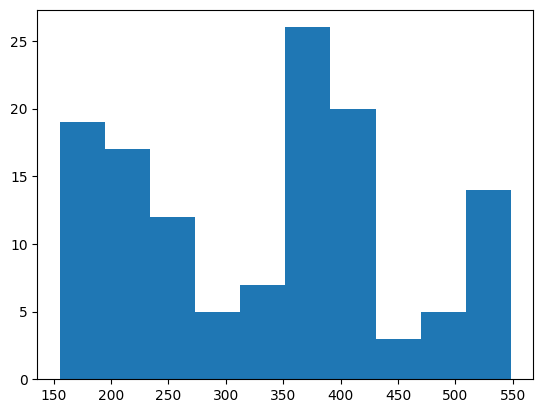

In [113]:
_ = plt.hist(theta_file['theta_R'][:, 14])